In [1]:
import torch
#collections是python一个内置模块，提供了一些有用的数据结构
from collections import OrderedDict  #这个类是字典dict的一个子类，用于创建有序的字典。普通字典中元素顺序是无序的，在OrderedDict中元素的顺序是有序的，元素的顺序是按照它们被添加到字典中的顺序决定的。

from pyDOE import lhs #`pyDOE`是一个Python库，用于设计实验。它提供了一些函数来生成各种设计，如因子设计、拉丁超立方设计等。`lhs`是库中的一个函数，全名为"Latin Hypercube Sampling"，拉丁超立方采样。这是一种统计方法，用于生成一个近似均匀分布的多维样本点集。它在参数空间中生成一个非常均匀的样本，这对于高维数值优化问题非常有用，因为它可以更好地覆盖参数空间。
import numpy as np
import matplotlib.pyplot as plt
import scipy.io #导入了scipy库中的io模块。scipy.io模块包含了一些用于文件输入/输出的函数，例如读取和写入.mat文件（MATLAB格式）
from scipy.interpolate import griddata #`scipy.interpolate`是`scipy`库中的一个模块，提供了许多插值工具，用于在给定的离散数据点之间进行插值和拟合。`griddata`是这个模块中的一个函数，用于在无规则的数据点上进行插值。

import random

import skopt #用于优化问题的库，特别是机器学习中的超参数优化
from distutils.version import LooseVersion #distutils是Python的一个标准库，用于构建和安装Python包。LooseVersion是一个类，用于比较版本号

from pyDOE import lhs #`pyDOE`是一个Python库，用于设计实验。它提供了一些函数来生成各种设计，如因子设计、拉丁超立方设计等。`lhs`是库中的一个函数，全名为"Latin Hypercube Sampling"，拉丁超立方采样。这是一种统计方法，用于生成一个近似均匀分布的多维样本点集。它在参数空间中生成一个非常均匀的样本，这对于高维数值优化问题非常有用，因为它可以更好地覆盖参数空间。


from mpl_toolkits.axes_grid1 import make_axes_locatable #`mpl_toolkits.axes_grid1`是`matplotlib`库的一个模块，提供了一些高级的工具来控制matplotlib图形中的坐标轴和颜色条。`make_axes_locatable`是模块中的一个函数，用于创建一个可分割的坐标轴。可以在这个坐标轴的四个方向（上、下、左、右）添加新的坐标轴或颜色条。
import matplotlib.gridspec as gridspec #是`matplotlib`库的一个模块，用于创建一个网格布局来放置子图。在`matplotlib`中可以创建一个或多个子图（subplot），每个子图都有自己的坐标轴，并可以在其中绘制图形。`gridspec`模块提供了一个灵活的方式来创建和放置子图。
import time #一个内置模块，用于处理时间相关的操作。


from tqdm import tqdm #一个快速，可扩展的python进度条库，可以在python长循环中添加一个进度提示信息，用户只需要封装任意的迭代器tqdm(iterator)。

import os
import pickle

import timeit #用于计时和测量小段代码的执行时间
import seaborn as sns  # 导入seaborn库用于绘制密度图
import pandas as pd #一个用于数据操作和分析的库，提供了数据结构和数据分析工具，特别是用于处理表格数据（类似于Excel中的数据表）

In [2]:
num_gpus = torch.cuda.device_count()
print('Number of available GPUs: ', num_gpus)

for i in range(num_gpus):
    torch.cuda.set_device(i)
    allocated = torch.cuda.memory_allocated()
    reserved = torch.cuda.memory_reserved()
    print('GPU {}: {}, Allocated: {}, Reserved: {}'.format(i, torch.cuda.get_device_name(i), allocated, reserved))

Number of available GPUs:  2
GPU 0: NVIDIA GeForce RTX 4090, Allocated: 0, Reserved: 0
GPU 1: NVIDIA GeForce RTX 4090, Allocated: 0, Reserved: 0


In [3]:
torch.cuda.set_device(0) #设置当前使用的GPU设备。这里设置为1号GPU设备（第二块显卡）。

# CUDA support 

#设置pytorch的设备，代表了在哪里执行张量积算，设备可以是cpu或者cuda（gpu），并将这个做运算的设备对象存储在变量device中，后续张量计算回在这个设备上执行
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [4]:
# the deep neural network
class DNN(torch.nn.Module):
    #第一个方法
    def __init__(self, layers):
        super(DNN, self).__init__() #调用父类的__init__方法进行初始化
        
        # parameters
        self.depth = len(layers) - 1 #定义名为depth的属性，表示神经网络的深度，等于层数-1
        
        # set up layer order dict
        self.activation = torch.nn.Tanh #设置激活函数为tanh
         
        layer_list = list() #定义一个空列表layer_list
        for i in range(self.depth - 1):  #循环depth次
            #将每一层（全连接层）添加到layer_list中
            layer_list.append(
                ('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1]))
            )
            #将每一层的激活函数添加到layer_list中
            layer_list.append(('activation_%d' % i, self.activation()))

        #循环结束后，将最后一层的线性变换添加到layer_list中（激活函数为softmax）
        layer_list.append(
            ('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1]))
        )
        #输出层的激活函数为tanh
        layer_list.append(('activation_%d' % (self.depth - 1), torch.nn.Softmax(dim=1)))  

        #然后使用OrderedDict将layer_list中的元素转换为有序字典
        layerDict = OrderedDict(layer_list)
        
        # deploy layers，将layerDict转换为一个神经网络模型，赋值给self.layers
        self.layers = torch.nn.Sequential(layerDict) #layers，长度为2*depth，包含了所有的线性变换和激活函数，奇数索引为线性变换(权重矩阵)，偶数索引为激活函数
    
    #第二个方法，定义了模型的前向传播过程
    def forward(self, x):  #接收输入x
        out = self.layers(x) #将输入x传入神经网络模型self.layers中，得到输出out
        return out #返回输出out
    
    # # 新增方法，获取最后一个隐藏层的输出
    # def hidden_output(self, x):
    #     # 遍历每一层，直到最后一个隐藏层
    #     for i in range(self.depth - 1):
    #         # 获取当前层的线性变换
    #         x = self.layers[i*2](x)
    #         # 获取当前层的激活函数
    #         x = self.layers[i*2 + 1](x)
    #     # 返回最后一个隐藏层的输出
    #     return x

    # 新增方法，循环传递输入
    def hidden_forward(self, x, num_cycles):
        # 将输入传递到最后一个隐藏层，x为最后一个隐藏层的输出
        for i in range(self.depth - 1):
            x = self.layers[i*2](x)
            x = self.layers[i*2 + 1](x)
        
        # 将最后一个隐藏层的输出作为输入传递到第一个隐藏层中，重复num_cycles次
        for _ in range(num_cycles):
            for i in range(1, self.depth - 1): #最开始的x为最后一个隐藏层的输出，然后从第一个隐藏层开始传递
                x = self.layers[i*2](x)
                x = self.layers[i*2 + 1](x)
        hidden_output = x
        
        return hidden_output

In [5]:
# the physics-guided neural network
class PhysicsInformedNN():
    # Initialize the class
    def __init__(self, X_u, u, X_f, layers, lb, ub): #这个类包含的第一个方法__init__，这是一个特殊的方法，也就是这个类的构造函数，用于初始化新创建的对象，接受了几个参数

        mu_x, sigma_x = X_f.mean(0), X_f.std(0) #计算X_u的均值和标准差
        X_u = (X_u - mu_x) / sigma_x #对X_u进行标准化
        X_f = (X_f - mu_x) / sigma_x #对X_f进行标准化

        self.mu_x = torch.tensor(mu_x).float().to(device) #创建一个pytorch张量（数据来源于mu_x），并将其转换为浮点类型，最后将张量移动到指定的设备上
        self.sigma_x = torch.tensor(sigma_x).float().to(device) #创建一个pytorch张量（数据来源于sigma_x），并将其转换为浮点类型，最后将张量移动到指定的设备上

        # boundary conditions
        #将传入的lb和ub参数的值存储在实例中，以便后续使用。这样可以在类的其他方法中通过self.lb和self.ub来访问这些值。
        self.lb = torch.tensor(lb).float().to(device) #创建一个pytorch张量（数据来源于lb），并将其转换为浮点类型，最后将张量移动到指定的设备上
        self.ub = torch.tensor(ub).float().to(device)
        
        # data
        #初边界点数据
        self.X_u = torch.tensor(X_u, requires_grad=True).float().to(device)
        #初边界点真实数据
        self.u = torch.tensor(u).float().to(device)
        #配位点数据
        self.X_f = torch.tensor(X_f, requires_grad=True).float().to(device)
        # #测试点数据
        # self.X_star = torch.tensor(X_star).float().to(device)
        # #测试点真实数据
        # self.u_star = torch.tensor(u_star).float().to(device)
        
        self.layers = layers
        
        # deep neural networks
        self.dnn = DNN(layers).to(device) #创建一个DNN类的实例，传入layers参数来实现神经网络的初始化，然后将这个实例移动到指定的设备上
        
        # optimizers: using the same settings
        #创建优化器，括号内为要优化的参数，使用Adam优化方法
        self.optimizer_Adam = torch.optim.Adam(self.dnn.parameters(), eps = 1e-8) 


        self.iter = 0 #记录迭代次数 

        self.loss_value = [] #创建一个空列表，用于存储损失值

        self.test_error = [] #创建一个空列表，用于存储测试误差
        self.test_error_mse = [] #创建一个空列表，用于存储测试误差
        self.test_error_mae = [] #创建一个空列表，用于存储测试误差
        
    #主动学习更新配位点数据    
    def update_data(self, X_u, u, X_f):
        mu_x, sigma_x = X_f.mean(0), X_f.std(0)
        X_u = (X_u - mu_x) / sigma_x
        X_f = (X_f - mu_x) / sigma_x

        self.mu_x = torch.tensor(mu_x).float().to(device)
        self.sigma_x = torch.tensor(sigma_x).float().to(device)
        
        self.X_u = torch.tensor(X_u, requires_grad=True).float().to(device)
        self.u = torch.tensor(u).float().to(device)
        self.X_f = torch.tensor(X_f, requires_grad=True).float().to(device)
    
    
    #定义了一个名为net_u的函数/方法，用于计算神经网络的输出。这个方法接受两个参数，分别是x和t，其中x是输入数据，t是时间数据。最后返回神经网络的输出。     
    def net_u(self, x):  
        u = self.dnn(x)  #（第一个参数将输入的两个参数x和t在第二个维度（列）上进行拼接，形成一个新的张量）调用DNN，根据两个参数权重和偏置，以及新得到的张量，计算神经网络的输出u
        return u
    
    #定义了一个名为net_f的函数/方法，用于计算论文中的f。这个方法接受两个参数，分别是x和t，其中x是输入数据，t是时间数据。最后返回计算得到的f。
    def net_f(self, x):
        """ The pytorch autograd version of calculating residual """
        u = self.net_u(x) #调用上面的net_u函数，计算神经网络的输出u
        u1 = u[:, 0:1] #取u的第一列，对应状态1
        u2 = u[:, 1:2] #取u的第二列，对应状态2
        u3 = u[:, 2:3] #取u的第三列，对应状态3

        u_x_1 = torch.autograd.grad(
            u1, x, #输入的张量，要计算u1关于x的导数
            grad_outputs=torch.ones_like(u1), #生成一个与u1形状相同，所有元素均为1的张量，这个参数用于指定向量-雅可比积的像两部分
            retain_graph=True, #表示计算完梯度之后保留计算图若需要多次计算梯度，则需要设置改参数为True
            create_graph=True #创建梯度的计算图，使我们能够计算高阶导数
        )[0] #这个函数的返回值是一个元组，其中包含了每个输入张量的梯度。这里只关心第一个输入张量u1的梯度，所以我们使用[0]来获取这个梯度。？？？？又说只有一个梯度
        u_x_2 = torch.autograd.grad(
            u2, x, #输入的张量，要计算u2关于x的导数
            grad_outputs=torch.ones_like(u2), #生成一个与u2形状相同，所有元素均为1的张量，这个参数用于指定向量-雅可比积的像两部分
            retain_graph=True, #表示计算完梯度之后保留计算图若需要多次计算梯度，则需要设置改参数为True
            create_graph=True #创建梯度的计算图，使我们能够计算高阶导数
        )[0] #这个函数的返回值是一个元组，其中包含了每个输入张量的梯度。这里只关心第一个输入张量u2的梯度，所以我们使用[0]来获取这个梯度。？？？？又说只有一个梯度
        u_x_3 = torch.autograd.grad(
            u3, x, #输入的张量，要计算u3关于x的导数
            grad_outputs=torch.ones_like(u3), #生成一个与u3形状相同，所有元素均为1的张量，这个参数用于指定向量-雅可比积的像两部分
            retain_graph=True, #表示计算完梯度之后保留计算图若需要多次计算梯度，则需要设置改参数为True
            create_graph=True #创建梯度的计算图，使我们能够计算高阶导数
        )[0] #这个函数的返回值是一个元组，其中包含了每个输入张量的梯度。这里只关心第一个输入张量u3的梯度，所以我们使用[0]来获取这个梯度。？？？？又说只有一个梯度

        #归一化
        u_x_1 = u_x_1 / self.sigma_x
        u_x_2 = u_x_2 / self.sigma_x
        u_x_3 = u_x_3 / self.sigma_x
        
        #计算残差
        residual_1 = u_x_1-(-1.286e-4*u1)
        residual_2 = u_x_2-(5.6e-5*u1-1.006e-4*u2)
        residual_3 = u_x_3-(7.26e-5*u1+1.006e-4*u2)

        loss_1 = torch.mean(residual_1 ** 2)
        loss_2 = torch.mean(residual_2 ** 2)
        loss_3 = torch.mean(residual_3 ** 2)

        loss_f = loss_1 + loss_2 + loss_3
        return loss_f, residual_1 + residual_2 + residual_3
    
      
    
    def train(self, nIter):


        #使用Adam优化器优化nIter次
        for epoch in range(nIter):
            self.dnn.train() #将神经网络设置为训练模式而不是评估模式
            u_pred = self.net_u(self.X_u) #调用之前定义的函数，传入初值得到神经网络的输出u

            loss_u = torch.mean((self.u - u_pred) ** 2) #计算初值的损失函数
            loss_f, _ = self.net_f(self.X_f) #计算残差的损失函数
            

            loss = loss_u + loss_f
            
            # Backward and optimize
            self.optimizer_Adam.zero_grad() #清除该优化器之前计算的梯度（在PyTorch中，梯度会累积，所以在每次新的优化迭代之前，我们需要清除之前的梯度）
            loss.backward() #被调用以计算损失函数关于神经网络参数的梯度。这个梯度将被用于优化器来更新神经网络参数
            self.optimizer_Adam.step()  #使用之前的优化器self.optimizer_Adam，调用step方法(执行一步优化算法)，传入损失函数self.loss_func，进行优化
            
            #record the loss value
            self.loss_value.append(loss) #将计算得到的loss值添加到self.loss_value列表中

            # # record the test error
            # self.dnn.eval() #将神经网络切换为评估模式
            # with torch.no_grad():
            #     u_real_pred = self.net_u(self.x_star, self.t_star) #调用之前定义的函数，传入参数得到神经网络的输出u


            # error_test = torch.norm(self.u_star-u_real_pred,2)/torch.norm(self.u_star,2)

            # self.test_error.append(error_test)

            # # 计算 MAE和MSE
            # mae = torch.mean(torch.abs(self.u_star - u_real_pred))
            # mse = torch.mean((self.u_star - u_real_pred) ** 2)
            # # 记录 MAE 和 MSE
            # self.test_error_mae.append(mae)
            # self.test_error_mse.append(mse)


  

    def predict(self, X):
        x = torch.tensor(X, requires_grad=True).float().to(device) #从输入中得到x和t（第一列和第二列），是张量，需要计算梯度，转换为浮点数类型，并将张量移动到指定设备上
        mu, sigma = self.mu_x, self.sigma_x
        x = (x - mu) / sigma

        self.dnn.eval() #将神经网络切换为评估模式
        u = self.net_u(x) #调用之前定义的函数得到神经网络的输出u,以及f
        _, f = self.net_f(x)
        u = u.detach().cpu().numpy() #将张量u和f先从计算图中分离出来，然后转换为numpy数组，最后将这个数组移动到cpu上
        f = f.detach().cpu().numpy()
        return u, f
    

    def hidden_predict(self, x, num_cycles):
        x = torch.tensor(x, requires_grad=True).float().to(device) #从输入中得到x和t（第一列和第二列），是张量，需要计算梯度，转换为浮点数类型，并将张量移动到指定设备上
        mu, sigma = self.mu_x, self.sigma_x
        x = (x - mu) / sigma

        self.dnn.eval()
        hidden_output = self.dnn.hidden_forward(x, num_cycles)
        hidden_output = hidden_output.detach().cpu().numpy()
        return hidden_output

In [6]:
#定义设置随机数种子的函数，第一个参数seed表示种子；第二个参数用来设置CUDA的卷积操作是否确定性，默认为False，表示没有确定性
def set_seed(seed):
    # torch.manual_seed(seed) #设置pytorch的CPU随机数生成器的种子
    # torch.cuda.manual_seed_all(seed) #设置putorch的所有GPU随机数生成器的种子
    # np.random.seed(seed) #设置numpy的随机数生成器的种子
    # random.seed(seed) #设置python的内置随机数生成器的种子
    # torch.backends.cudnn.deterministic = deterministic #True会让CUDA的卷积操作变得确定性，即对于相同的输入，每次运行会得到相同的结果，False则相反
    """
    设置PyTorch的随机种子, 用于生成随机数. 通过设置相同的种子, 可以确保每次运行时生成的随机数序列相同
    """
    torch.manual_seed(seed)
 
    """
    设置PyTorch在所有可用的CUDA设备上的随机种子. 如果在使用GPU进行计算, 这个设置可以确保在不同的GPU上生成的随机数序列相同
    """
    torch.cuda.manual_seed_all(seed)
 
    """
    设置PyTorch在当前CUDA设备上的随机种子. 它与上一行代码的作用类似, 但只影响当前设备
    """
    torch.cuda.manual_seed(seed)
 
    """
    设置NumPy的随机种子, 用于生成随机数. 通过设置相同的种子，可以确保在使用NumPy的随机函数时生成的随机数序列相同
    """
    np.random.seed(seed)
    
    """
    设置Python内置的随机函数的种子. Python的random模块提供了许多随机函数, 包括生成随机数、打乱列表等. 通过设置相同的种子, 可以确保使用这些随机函数时生成的随机数序列相同
    """
    random.seed(seed)
    
    """
    设置Python的哈希种子 (哈希函数被广泛用于数据结构 (如字典和集合) 的实现，以及一些内部操作 (如查找和比较)). 通过设置相同的种子, 可以确保在不同的运行中生成的哈希结果相同
    """
    # os.environ["PYTHONHASHSEED"] = str(seed)
    
    """
    该设置确保每次运行代码时, cuDNN的计算结果是确定性的, 即相同的输入会产生相同的输出, 这是通过禁用一些非确定性的算法来实现的, 例如在卷积操作中使用的算法. 这样做可以保证模型的训练和推理在相同的硬件和软件环境下是可复现的, 即每次运行代码时的结果都相同. 但是, 这可能会导致一些性能上的损失, 因为禁用了一些优化的非确定性算法
    """
    torch.backends.cudnn.deterministic = True
    
    """
    该设置禁用了cuDNN的自动优化过程. 当它被设置为False时, PyTorch不会在每次运行时重新寻找最优的算法配置, 而是使用固定的算法配置. 这样做可以确保每次运行代码时的性能是一致的, 但可能会导致一些性能上的损失
    """
    torch.backends.cudnn.benchmark = False



In [7]:
#RAR-G方法，对1000个点，先选择10个点训练500次，然后每500次迭代重采样100个点，选出其中残差最大的10个点添加到训练点中；最后总共有1000个点，共训练10000次
# seeds = [0, 1, 12, 33, 123, 321, 1234, 4321, 12345, 54321] #生成10个随机种子
set_seed(0) #设置随机数种子
seeds = [random.randint(0, 100000) for _ in range(200)]
# seeds = [0]
#设置噪声水平为0
noise = 0.0        

#读取真实解
eigenvector_solution_df = pd.read_csv('analytical_solution_by_eigenvector_method.csv')
eigenvector_solution_df.columns = ['state_0', 'state_1', 'state_2']

N_u = 1
N_f = 2500

#定义一个列表layers，其中包含了神经网络的层数和每一层的神经元数量
layers = [1, 50, 50, 3]

lb  = np.array([0.0])              # t的左边界
ub  = np.array([60000.0])          # t的右边界

# Define the initial MSS state
X_u = np.array([[0]])
u = np.array([[1,0,0]])          # 初始真实状态
# X_f = np.linspace(lb, ub, N_f)     # 配位点位置，0~60000的5000个点

error_y = [] #创建一个空列表，用于存储误差值
error_mae = [] #创建一个空列表，用于存储MAE值
error_mse = [] #创建一个空列表，用于存储MSE值
chaoss = [] #创建一个空列表，用于存储chaos值
residuals = [] #创建一个空列表，用于存储residual值

i = 0 #初始化i为0

# # 创建文件夹
# model_dir = 'Adam+LBFGS+LHS(5000)'
# if not os.path.exists(model_dir):
#     os.makedirs(model_dir)

for seed in seeds:
    set_seed(seed) #设置随机数种子

    N_f_1 = N_f // 100 #先拿50个点训练
    X_f_train = lb + (ub - lb) * lhs(1, N_f_1) #生成N_f个随机点
    nIter = 80000 #设置迭代次数为10000

    #创建PINN模型并输入各种参数     
    model = PhysicsInformedNN(X_u, u, X_f_train, layers, lb, ub)

    #获取当前时间并赋值给start_time  
    start_time = time.time()   
    #开始训练模型            
    model.train(nIter//100)


    for iter in range(nIter//100+1, nIter+1, nIter//100): #每800次迭代
        N_f_new = N_f_1 * 10 #重新采样500个点
        X_f_train_new = lb + (ub - lb) * lhs(1, N_f_new) #生成N_f_new个随机点

        #计算残差
        _, residual = model.predict(X_f_train_new)
        abs_residual = np.abs(residual)
        abs_residual = abs_residual.flatten()
        #对abs_residual进行归一化
        abs_residual = abs_residual / np.linalg.norm(abs_residual)


        #计算混沌度
        y_chaos = model.hidden_predict(X_f_train_new, 100)
        x_ssss = X_f_train_new + np.random.normal(0, 0.001)
        y_chaos_ssss = model.hidden_predict(x_ssss, 100)
        chaos = np.linalg.norm(y_chaos - y_chaos_ssss,axis=1)
        #对chaos进行归一化
        epsilon = 1e-10
        norm_chaos = np.linalg.norm(chaos)
        if norm_chaos > epsilon:
            chaos = chaos / norm_chaos
        else:
            chaos = np.zeros_like(chaos)

        #计算信息量
        xinxi = abs_residual + chaos

        #选出信息量最大的10个点
        # 找出绝对值最大的10个值的索引
        topk_indices = np.argpartition(xinxi, -N_f_1)[-N_f_1:] #该函数会对数组进行排序，使得指定的k个最大值出现在数组的最后k给位置上，并获取最后1000个元素

        # 使用这些索引来提取对应的数据
        X_f_train_topk = X_f_train_new[topk_indices]

        X_f_train = np.vstack((X_f_train, X_f_train_topk)) #与之前的训练数据合并

        # 更新模型中的X_f_train数据
        model.update_data(X_u, u, X_f_train)

        # 在更新数据后的模型上进行训练500次
        model.train(nIter//100)

    # print(X_f_train.shape)
    # 更新模型中的X_f_train数据
    model.update_data(X_u, u, X_f_train)
    #训练结束后获取当前时间并减去start_time，得到训练时间并赋值给elapsed
    elapsed = time.time() - start_time
    #打印训练所花时间                
    print('Training time: %.4f' % (elapsed))

    #真实值
    mu, sigma = model.mu_x, model.sigma_x

    up = 80000
    n_star = 5000+1
    x_star = np.linspace(lb, up, n_star)[1:] #N_star = x_star.shape[0] 
    y_pred, _ = model.predict(x_star)
    y_star = eigenvector_solution_df


    #计算误差（基于2范数）        
    error_y.append(np.linalg.norm(y_star-y_pred,2)/np.linalg.norm(y_star,2)) #计算误差，然后将误差添加到error_u列表中             
    # 计算 MAE 和 MSE
    mae = np.mean(np.abs(y_star - y_pred))
    mse = np.mean((y_star - y_pred) ** 2)
    # 记录 MAE 和 MSE
    error_mae.append(mae)
    error_mse.append(mse)


    #计算混沌度
    y_chaos = model.hidden_predict(x_star, 100)
    # print(y_chaos)
    x_sss = x_star + np.random.normal(0, 0.001)
    y_chaos_sss = model.hidden_predict(x_sss, 50)
    chaos = np.linalg.norm(y_chaos - y_chaos_sss,axis=1).sum()
    chaoss.append(chaos)

    #计算残差

    _, residual = model.predict(x_star)
    residual = residual.flatten()
    residual = np.abs(residual)
    residual = residual.sum()
    residuals.append(residual)

    i+=1 #i加1
    print(f'当前为第{i}次循环，种子为{seed}')
    print('Error y : %e' % (np.linalg.norm(y_star-y_pred,2)/np.linalg.norm(y_star,2))) #打印误差  
    print('MAE: %e' % mae) #打印MAE
    print('MSE: %e' % mse) #打印MSE
    print('Chaos: %e' % chaos) #打印混沌度
    print('Residual: %e' % residual) #打印残差
    # # 保存模型到文件夹
    # model_path = os.path.join(model_dir, f'model_{i}_seed_{seed}.pkl')
    # with open(model_path, 'wb') as f:
    #     pickle.dump(model, f)


Training time: 119.9176
当前为第1次循环，种子为8906
Error y : 3.773733e-02
MAE: 1.809527e-02
MSE: 5.824257e-04
Chaos: 3.539716e+01
Residual: 3.121102e-08


Training time: 125.9306
当前为第2次循环，种子为30414
Error y : 4.230634e-02
MAE: 2.171804e-02
MSE: 7.832987e-04
Chaos: 1.321236e+03
Residual: 3.432729e-08


Training time: 124.3960
当前为第3次循环，种子为19997
Error y : 3.917636e-02
MAE: 2.028461e-02
MSE: 6.854776e-04
Chaos: 1.087652e+01
Residual: 3.086666e-08


Training time: 125.3650
当前为第4次循环，种子为79957
Error y : 3.883124e-02
MAE: 1.816366e-02
MSE: 5.937491e-04
Chaos: 1.628996e-03
Residual: 3.346872e-08


Training time: 128.2414
当前为第5次循环，种子为55853
Error y : 4.190154e-02
MAE: 2.273662e-02
MSE: 8.031103e-04
Chaos: 1.753358e-03
Residual: 3.534024e-08


Training time: 190.5374
当前为第6次循环，种子为99438
Error y : 3.536446e-02
MAE: 1.800596e-02
MSE: 5.538123e-04
Chaos: 1.802636e+02
Residual: 3.314460e-08


Training time: 198.3263
当前为第7次循环，种子为17715
Error y : 3.805550e-02
MAE: 2.019293e-02
MSE: 6.622299e-04
Chaos: 2.046286e+04
Residual: 3.574303e-08


Training time: 199.6483
当前为第8次循环，种子为42674
Error y : 4.048240e-02
MAE: 2.138198e-02
MSE: 7.527773e-04
Chaos: 2.650713e-01
Residual: 3.231992e-08


Training time: 198.9756
当前为第9次循环，种子为97805
Error y : 3.809150e-02
MAE: 1.935062e-02
MSE: 6.601372e-04
Chaos: 1.322432e+01
Residual: 3.271691e-08


Training time: 197.1979
当前为第10次循环，种子为56382
Error y : 4.306798e-02
MAE: 2.129971e-02
MSE: 7.692236e-04
Chaos: 7.920504e+03
Residual: 3.042010e-08


Training time: 199.6380
当前为第11次循环，种子为60657
Error y : 3.388592e-02
MAE: 1.712902e-02
MSE: 5.074379e-04
Chaos: 2.054047e+02
Residual: 2.958939e-08


Training time: 202.9522
当前为第12次循环，种子为75478
Error y : 3.897153e-02
MAE: 2.038904e-02
MSE: 6.837347e-04
Chaos: 1.041569e+02
Residual: 3.219748e-08


Training time: 199.2733
当前为第13次循环，种子为20161
Error y : 4.409302e-02
MAE: 2.106371e-02
MSE: 7.887599e-04
Chaos: 3.319237e+00
Residual: 3.783464e-08


Training time: 200.0609
当前为第14次循环，种子为70579
Error y : 4.005600e-02
MAE: 2.102577e-02
MSE: 7.087412e-04
Chaos: 3.243383e+03
Residual: 3.017055e-08


Training time: 200.0006
当前为第15次循环，种子为5506
Error y : 4.265077e-02
MAE: 2.156227e-02
MSE: 7.953736e-04
Chaos: 9.650897e+02
Residual: 3.735067e-08


Training time: 200.9587
当前为第16次循环，种子为86879
Error y : 3.792561e-02
MAE: 2.002565e-02
MSE: 6.448692e-04
Chaos: 1.920784e+04
Residual: 3.101673e-08


Training time: 201.8124
当前为第17次循环，种子为5562
Error y : 4.561417e-02
MAE: 2.218913e-02
MSE: 8.730747e-04
Chaos: 1.648861e-03
Residual: 3.573587e-08


Training time: 198.6083
当前为第18次循环，种子为10712
Error y : 3.418141e-02
MAE: 1.810078e-02
MSE: 5.301627e-04
Chaos: 1.796135e+02
Residual: 3.170749e-08


Training time: 198.4217
当前为第19次循环，种子为10432
Error y : 4.783726e-02
MAE: 2.273454e-02
MSE: 9.465458e-04
Chaos: 3.335738e+03
Residual: 3.521222e-08


Training time: 199.6565
当前为第20次循环，种子为76078
Error y : 3.667463e-02
MAE: 1.894973e-02
MSE: 5.943667e-04
Chaos: 6.749052e-03
Residual: 2.749994e-08


Training time: 194.2169
当前为第21次循环，种子为26002
Error y : 3.476658e-02
MAE: 1.868086e-02
MSE: 5.525244e-04
Chaos: 6.437919e+02
Residual: 3.528976e-08


Training time: 138.7275
当前为第22次循环，种子为4367
Error y : 3.864423e-02
MAE: 1.988356e-02
MSE: 6.552806e-04
Chaos: 1.698062e-01
Residual: 2.838874e-08


Training time: 133.2280
当前为第23次循环，种子为71027
Error y : 4.163427e-02
MAE: 2.127969e-02
MSE: 7.512139e-04
Chaos: 4.424011e-02
Residual: 2.929619e-08


Training time: 132.8503
当前为第24次循环，种子为75144
Error y : 4.181769e-02
MAE: 2.213460e-02
MSE: 7.572052e-04
Chaos: 3.291079e-02
Residual: 3.086643e-08


Training time: 133.4165
当前为第25次循环，种子为5423
Error y : 4.500127e-02
MAE: 2.212700e-02
MSE: 7.872163e-04
Chaos: 1.406616e-03
Residual: 2.820161e-08


Training time: 132.7059
当前为第26次循环，种子为96542
Error y : 4.194273e-02
MAE: 1.988233e-02
MSE: 6.290647e-04
Chaos: 4.062047e+03
Residual: 2.559739e-08


Training time: 133.5322
当前为第27次循环，种子为97407
Error y : 3.821198e-02
MAE: 2.000370e-02
MSE: 6.616150e-04
Chaos: 8.916133e+01
Residual: 3.007312e-08


Training time: 133.4900
当前为第28次循环，种子为1251
Error y : 3.911269e-02
MAE: 1.920591e-02
MSE: 6.604343e-04
Chaos: 4.929313e-03
Residual: 3.866145e-08


Training time: 132.9406
当前为第29次循环，种子为24010
Error y : 4.230666e-02
MAE: 2.017533e-02
MSE: 7.185681e-04
Chaos: 1.085623e-03
Residual: 3.386401e-08


Training time: 131.7412
当前为第30次循环，种子为72817
Error y : 4.196893e-02
MAE: 2.231088e-02
MSE: 7.985117e-04
Chaos: 1.562799e-03
Residual: 2.616139e-08


Training time: 133.4034
当前为第31次循环，种子为16195
Error y : 4.033379e-02
MAE: 2.054359e-02
MSE: 7.192145e-04
Chaos: 1.407332e-03
Residual: 3.521632e-08


Training time: 133.3768
当前为第32次循环，种子为70599
Error y : 3.594058e-02
MAE: 1.885515e-02
MSE: 5.623087e-04
Chaos: 9.272959e-02
Residual: 2.844058e-08


Training time: 132.8236
当前为第33次循环，种子为37761
Error y : 4.003736e-02
MAE: 2.162971e-02
MSE: 7.303908e-04
Chaos: 9.823932e+03
Residual: 2.817706e-08


Training time: 131.2036
当前为第34次循环，种子为95319
Error y : 4.197159e-02
MAE: 2.266224e-02
MSE: 8.097591e-04
Chaos: 8.056460e+00
Residual: 3.869968e-08


Training time: 132.4103
当前为第35次循环，种子为88326
Error y : 4.365079e-02
MAE: 2.083640e-02
MSE: 7.764376e-04
Chaos: 2.071810e+01
Residual: 3.394450e-08


Training time: 132.4612
当前为第36次循环，种子为58646
Error y : 3.512322e-02
MAE: 1.850221e-02
MSE: 5.579988e-04
Chaos: 1.932541e-03
Residual: 3.092543e-08


Training time: 130.1328
当前为第37次循环，种子为53937
Error y : 4.019433e-02
MAE: 1.881312e-02
MSE: 6.249390e-04
Chaos: 1.566214e-03
Residual: 3.678744e-08


Training time: 124.7963
当前为第38次循环，种子为36297
Error y : 4.272840e-02
MAE: 1.921688e-02
MSE: 6.981623e-04
Chaos: 2.009040e-03
Residual: 3.185687e-08


Training time: 123.2876
当前为第39次循环，种子为21411
Error y : 3.936831e-02
MAE: 1.991206e-02
MSE: 6.756506e-04
Chaos: 1.269135e-03
Residual: 3.497883e-08


Training time: 124.2902
当前为第40次循环，种子为93932
Error y : 3.797403e-02
MAE: 2.043013e-02
MSE: 6.534784e-04
Chaos: 6.298938e+03
Residual: 3.573598e-08


Training time: 124.9664
当前为第41次循环，种子为10733
Error y : 4.275477e-02
MAE: 2.225875e-02
MSE: 8.194966e-04
Chaos: 1.183386e+00
Residual: 2.992851e-08


Training time: 124.9375
当前为第42次循环，种子为77855
Error y : 3.983300e-02
MAE: 2.143143e-02
MSE: 7.179804e-04
Chaos: 1.705026e+01
Residual: 2.936554e-08


Training time: 124.9923
当前为第43次循环，种子为45717
Error y : 3.786422e-02
MAE: 1.925972e-02
MSE: 6.288959e-04
Chaos: 1.412088e-03
Residual: 2.741933e-08


Training time: 124.3500
当前为第44次循环，种子为30700
Error y : 4.117934e-02
MAE: 2.162935e-02
MSE: 7.757865e-04
Chaos: 5.258098e-03
Residual: 3.516902e-08


Training time: 124.0452
当前为第45次循环，种子为22746
Error y : 3.930786e-02
MAE: 2.092350e-02
MSE: 6.994924e-04
Chaos: 5.317620e+00
Residual: 3.034415e-08


Training time: 123.6324
当前为第46次循环，种子为97990
Error y : 3.984980e-02
MAE: 1.995814e-02
MSE: 6.647217e-04
Chaos: 3.803543e+02
Residual: 3.334054e-08


Training time: 124.1841
当前为第47次循环，种子为97591
Error y : 3.963078e-02
MAE: 2.099743e-02
MSE: 6.932652e-04
Chaos: 8.732349e+00
Residual: 3.069601e-08


Training time: 124.2846
当前为第48次循环，种子为93206
Error y : 4.361163e-02
MAE: 2.265261e-02
MSE: 8.448650e-04
Chaos: 1.066127e+00
Residual: 2.949366e-08


Training time: 124.6845
当前为第49次循环，种子为43502
Error y : 3.943663e-02
MAE: 2.119938e-02
MSE: 7.232008e-04
Chaos: 3.452991e-03
Residual: 3.200125e-08


Training time: 124.2223
当前为第50次循环，种子为16228
Error y : 3.838353e-02
MAE: 2.112534e-02
MSE: 6.864342e-04
Chaos: 1.723746e-03
Residual: 3.075797e-08


Training time: 123.9300
当前为第51次循环，种子为56093
Error y : 4.107524e-02
MAE: 2.158386e-02
MSE: 7.442944e-04
Chaos: 5.294700e+02
Residual: 3.182663e-08


Training time: 124.5342
当前为第52次循环，种子为67707
Error y : 3.781455e-02
MAE: 1.896729e-02
MSE: 6.192342e-04
Chaos: 2.048448e-03
Residual: 3.186858e-08


Training time: 124.4302
当前为第53次循环，种子为90923
Error y : 4.510499e-02
MAE: 2.302424e-02
MSE: 8.877654e-04
Chaos: 6.666189e+03
Residual: 3.354762e-08


Training time: 124.6008
当前为第54次循环，种子为50475
Error y : 4.014062e-02
MAE: 2.146559e-02
MSE: 7.308279e-04
Chaos: 2.065475e+02
Residual: 3.246049e-08


Training time: 124.4326
当前为第55次循环，种子为32314
Error y : 4.590325e-02
MAE: 2.419774e-02
MSE: 8.855441e-04
Chaos: 1.287789e+01
Residual: 2.975344e-08


Training time: 124.5897
当前为第56次循环，种子为85533
Error y : 3.347682e-02
MAE: 1.830454e-02
MSE: 5.316133e-04
Chaos: 3.800647e-02
Residual: 3.076116e-08


Training time: 124.7620
当前为第57次循环，种子为68625
Error y : 3.981072e-02
MAE: 2.123364e-02
MSE: 7.277823e-04
Chaos: 1.200217e+03
Residual: 3.163427e-08


Training time: 123.3499
当前为第58次循环，种子为80550
Error y : 3.496263e-02
MAE: 1.864886e-02
MSE: 5.518262e-04
Chaos: 1.465333e-03
Residual: 2.861327e-08


Training time: 124.2788
当前为第59次循环，种子为90413
Error y : 4.349158e-02
MAE: 2.269091e-02
MSE: 8.446678e-04
Chaos: 7.429092e+01
Residual: 3.191622e-08


Training time: 124.2705
当前为第60次循环，种子为64944
Error y : 3.911071e-02
MAE: 2.066538e-02
MSE: 6.983741e-04
Chaos: 6.559060e-01
Residual: 3.349987e-08


Training time: 124.7240
当前为第61次循环，种子为60938
Error y : 3.851540e-02
MAE: 1.929001e-02
MSE: 6.280603e-04
Chaos: 2.677833e-01
Residual: 3.263199e-08


Training time: 124.3391
当前为第62次循环，种子为88697
Error y : 3.925070e-02
MAE: 2.038224e-02
MSE: 6.722036e-04
Chaos: 2.897104e-02
Residual: 2.919171e-08


Training time: 124.6758
当前为第63次循环，种子为80327
Error y : 3.890419e-02
MAE: 2.008811e-02
MSE: 6.749043e-04
Chaos: 1.574012e-01
Residual: 3.310026e-08


Training time: 123.7496
当前为第64次循环，种子为99021
Error y : 4.118144e-02
MAE: 2.190859e-02
MSE: 7.690004e-04
Chaos: 9.009187e-01
Residual: 3.250921e-08


Training time: 124.2191
当前为第65次循环，种子为67781
Error y : 4.002972e-02
MAE: 2.043071e-02
MSE: 6.461505e-04
Chaos: 3.330111e+02
Residual: 2.898332e-08


Training time: 124.5354
当前为第66次循环，种子为52438
Error y : 4.184935e-02
MAE: 2.231638e-02
MSE: 7.785262e-04
Chaos: 1.732982e+04
Residual: 3.264688e-08


Training time: 124.2977
当前为第67次循环，种子为18213
Error y : 3.842220e-02
MAE: 2.014195e-02
MSE: 6.667372e-04
Chaos: 1.405461e-03
Residual: 3.576383e-08


Training time: 124.9972
当前为第68次循环，种子为53755
Error y : 3.603235e-02
MAE: 1.684081e-02
MSE: 5.090596e-04
Chaos: 1.587684e-03
Residual: 3.212381e-08


Training time: 124.9404
当前为第69次循环，种子为63537
Error y : 3.689350e-02
MAE: 1.869279e-02
MSE: 5.925288e-04
Chaos: 7.026283e+01
Residual: 3.344826e-08


Training time: 125.1536
当前为第70次循环，种子为82672
Error y : 3.752665e-02
MAE: 1.787743e-02
MSE: 5.738715e-04
Chaos: 1.531272e-03
Residual: 3.614093e-08


Training time: 123.6257
当前为第71次循环，种子为72192
Error y : 3.958419e-02
MAE: 1.988570e-02
MSE: 6.751838e-04
Chaos: 7.302104e+01
Residual: 3.426692e-08


Training time: 123.9790
当前为第72次循环，种子为10130
Error y : 4.026531e-02
MAE: 2.046638e-02
MSE: 7.042629e-04
Chaos: 2.641769e-03
Residual: 3.229729e-08


Training time: 124.3552
当前为第73次循环，种子为5649
Error y : 4.315335e-02
MAE: 1.938025e-02
MSE: 7.105644e-04
Chaos: 1.193387e+02
Residual: 3.684625e-08


Training time: 124.6562
当前为第74次循环，种子为69169
Error y : 4.442359e-02
MAE: 2.168651e-02
MSE: 8.336397e-04
Chaos: 3.453031e-03
Residual: 2.756678e-08


Training time: 124.3979
当前为第75次循环，种子为64026
Error y : 4.010212e-02
MAE: 2.039452e-02
MSE: 7.118168e-04
Chaos: 6.190499e+03
Residual: 3.863249e-08


Training time: 124.4897
当前为第76次循环，种子为27219
Error y : 3.736954e-02
MAE: 1.819107e-02
MSE: 5.849506e-04
Chaos: 1.490194e+01
Residual: 3.361993e-08


Training time: 124.3796
当前为第77次循环，种子为70514
Error y : 3.377853e-02
MAE: 1.761024e-02
MSE: 5.092833e-04
Chaos: 7.428652e+02
Residual: 3.091026e-08


Training time: 124.2351
当前为第78次循环，种子为70064
Error y : 4.657800e-02
MAE: 2.250825e-02
MSE: 9.481892e-04
Chaos: 1.665284e+02
Residual: 3.403670e-08


Training time: 124.1605
当前为第79次循环，种子为93292
Error y : 3.795440e-02
MAE: 1.888443e-02
MSE: 6.096994e-04
Chaos: 1.553217e-03
Residual: 3.645857e-08


Training time: 124.7296
当前为第80次循环，种子为88433
Error y : 5.322588e-02
MAE: 2.668502e-02
MSE: 1.092194e-03
Chaos: 6.768596e+02
Residual: 2.715205e-08


Training time: 124.7958
当前为第81次循环，种子为43312
Error y : 3.557661e-02
MAE: 1.948606e-02
MSE: 5.976540e-04
Chaos: 2.803742e-03
Residual: 3.505704e-08


Training time: 123.6948
当前为第82次循环，种子为39283
Error y : 3.784943e-02
MAE: 2.106469e-02
MSE: 6.853694e-04
Chaos: 1.072342e-01
Residual: 3.122432e-08


Training time: 124.2024
当前为第83次循环，种子为22046
Error y : 4.340678e-02
MAE: 2.025670e-02
MSE: 7.289344e-04
Chaos: 7.329848e+01
Residual: 3.226461e-08


Training time: 124.0826
当前为第84次循环，种子为22017
Error y : 4.202485e-02
MAE: 2.237195e-02
MSE: 7.863548e-04
Chaos: 5.693109e-01
Residual: 2.789091e-08


Training time: 123.5293
当前为第85次循环，种子为4779
Error y : 3.713592e-02
MAE: 1.974658e-02
MSE: 6.348692e-04
Chaos: 2.258247e-03
Residual: 3.126161e-08


Training time: 124.6052
当前为第86次循环，种子为48009
Error y : 3.761263e-02
MAE: 1.880891e-02
MSE: 5.923767e-04
Chaos: 2.633796e+00
Residual: 3.300863e-08


Training time: 124.5809
当前为第87次循环，种子为79834
Error y : 4.053783e-02
MAE: 2.056729e-02
MSE: 7.242116e-04
Chaos: 3.682841e+00
Residual: 3.419780e-08


Training time: 124.6386
当前为第88次循环，种子为31429
Error y : 3.650050e-02
MAE: 1.797650e-02
MSE: 5.630805e-04
Chaos: 7.311177e-02
Residual: 3.463344e-08


Training time: 123.0837
当前为第89次循环，种子为73667
Error y : 4.301850e-02
MAE: 2.282012e-02
MSE: 8.399348e-04
Chaos: 1.676427e-03
Residual: 3.230616e-08


Training time: 123.7707
当前为第90次循环，种子为57132
Error y : 4.052586e-02
MAE: 2.054872e-02
MSE: 7.132555e-04
Chaos: 8.105800e+00
Residual: 3.773732e-08


Training time: 123.5232
当前为第91次循环，种子为71312
Error y : 4.467533e-02
MAE: 2.234128e-02
MSE: 8.710218e-04
Chaos: 1.556549e-03
Residual: 3.206230e-08


Training time: 124.3969
当前为第92次循环，种子为21860
Error y : 4.307942e-02
MAE: 1.991779e-02
MSE: 7.154388e-04
Chaos: 1.790073e-03
Residual: 3.776086e-08


Training time: 124.3780
当前为第93次循环，种子为25657
Error y : 4.285957e-02
MAE: 2.167462e-02
MSE: 7.710249e-04
Chaos: 1.599769e+04
Residual: 3.016453e-08


Training time: 123.9858
当前为第94次循环，种子为13923
Error y : 4.846567e-02
MAE: 2.417516e-02
MSE: 1.026606e-03
Chaos: 1.174352e+03
Residual: 3.476248e-08


Training time: 124.2635
当前为第95次循环，种子为43140
Error y : 3.995556e-02
MAE: 2.088474e-02
MSE: 7.384712e-04
Chaos: 6.454954e-02
Residual: 3.369530e-08


Training time: 124.4050
当前为第96次循环，种子为43106
Error y : 4.236666e-02
MAE: 2.268509e-02
MSE: 8.206296e-04
Chaos: 1.202286e+01
Residual: 3.118566e-08


Training time: 124.4755
当前为第97次循环，种子为63193
Error y : 4.250690e-02
MAE: 2.128116e-02
MSE: 7.798212e-04
Chaos: 2.902748e+01
Residual: 3.796390e-08


Training time: 124.2559
当前为第98次循环，种子为94994
Error y : 3.706752e-02
MAE: 1.864698e-02
MSE: 5.847683e-04
Chaos: 2.335084e+04
Residual: 2.929073e-08


Training time: 124.4072
当前为第99次循环，种子为69985
Error y : 4.218399e-02
MAE: 2.198126e-02
MSE: 8.008236e-04
Chaos: 1.737711e+00
Residual: 3.284390e-08


Training time: 124.2510
当前为第100次循环，种子为37369
Error y : 4.342081e-02
MAE: 2.300084e-02
MSE: 8.509565e-04
Chaos: 9.762928e-02
Residual: 3.357763e-08


Training time: 123.1103
当前为第101次循环，种子为70117
Error y : 4.143785e-02
MAE: 1.986612e-02
MSE: 6.948623e-04
Chaos: 2.491223e+02
Residual: 3.392256e-08


Training time: 123.9906
当前为第102次循环，种子为17196
Error y : 4.237239e-02
MAE: 2.211624e-02
MSE: 7.895368e-04
Chaos: 1.941033e-02
Residual: 3.413095e-08


Training time: 124.2144
当前为第103次循环，种子为39378
Error y : 3.663707e-02
MAE: 1.896637e-02
MSE: 5.864013e-04
Chaos: 2.614071e-03
Residual: 3.500611e-08


Training time: 124.9423
当前为第104次循环，种子为72911
Error y : 4.138204e-02
MAE: 2.250556e-02
MSE: 7.961858e-04
Chaos: 1.221479e+04
Residual: 3.470484e-08


Training time: 124.5687
当前为第105次循环，种子为92026
Error y : 3.758685e-02
MAE: 1.986541e-02
MSE: 6.411137e-04
Chaos: 3.325383e+02
Residual: 3.403795e-08


Training time: 124.4777
当前为第106次循环，种子为28810
Error y : 3.697756e-02
MAE: 1.902652e-02
MSE: 6.077599e-04
Chaos: 1.989067e-03
Residual: 3.401067e-08


Training time: 124.4481
当前为第107次循环，种子为26335
Error y : 3.685456e-02
MAE: 1.859570e-02
MSE: 5.941381e-04
Chaos: 8.068067e-02
Residual: 3.383479e-08


Training time: 124.4935
当前为第108次循环，种子为52398
Error y : 3.676725e-02
MAE: 1.927450e-02
MSE: 5.989371e-04
Chaos: 8.597455e+01
Residual: 2.830848e-08


Training time: 124.7086
当前为第109次循环，种子为99110
Error y : 4.935421e-02
MAE: 2.431084e-02
MSE: 9.902163e-04
Chaos: 5.278971e+00
Residual: 3.587513e-08


Training time: 124.6775
当前为第110次循环，种子为9859
Error y : 3.978081e-02
MAE: 2.122998e-02
MSE: 6.997283e-04
Chaos: 1.470686e-03
Residual: 3.024843e-08


Training time: 124.4859
当前为第111次循环，种子为57350
Error y : 4.474337e-02
MAE: 2.188494e-02
MSE: 8.407007e-04
Chaos: 2.690404e-03
Residual: 3.061189e-08


Training time: 124.0749
当前为第112次循环，种子为24427
Error y : 3.945649e-02
MAE: 2.069919e-02
MSE: 7.108282e-04
Chaos: 6.299116e-04
Residual: 3.398191e-08


Training time: 123.2809
当前为第113次循环，种子为75209
Error y : 3.922901e-02
MAE: 2.149034e-02
MSE: 7.148011e-04
Chaos: 4.807333e+03
Residual: 3.196328e-08


Training time: 124.3738
当前为第114次循环，种子为46879
Error y : 4.534641e-02
MAE: 2.328565e-02
MSE: 9.244856e-04
Chaos: 2.153395e+02
Residual: 3.101809e-08


Training time: 123.9765
当前为第115次循环，种子为98222
Error y : 4.559534e-02
MAE: 2.368501e-02
MSE: 9.307789e-04
Chaos: 3.580252e+02
Residual: 3.244531e-08


Training time: 124.2710
当前为第116次循环，种子为81616
Error y : 3.865904e-02
MAE: 2.095137e-02
MSE: 6.829258e-04
Chaos: 7.593101e-03
Residual: 3.433013e-08


Training time: 123.0782
当前为第117次循环，种子为91622
Error y : 3.609765e-02
MAE: 1.962750e-02
MSE: 6.149641e-04
Chaos: 1.231669e+04
Residual: 3.580783e-08


Training time: 124.4483
当前为第118次循环，种子为34088
Error y : 4.545650e-02
MAE: 1.990174e-02
MSE: 7.495268e-04
Chaos: 1.811350e-03
Residual: 3.695686e-08


Training time: 124.1292
当前为第119次循环，种子为72375
Error y : 4.393685e-02
MAE: 2.315769e-02
MSE: 8.381505e-04
Chaos: 2.190084e+01
Residual: 2.981153e-08


Training time: 124.1486
当前为第120次循环，种子为28603
Error y : 4.383223e-02
MAE: 1.927043e-02
MSE: 6.952358e-04
Chaos: 2.321864e+03
Residual: 3.629816e-08


Training time: 124.4843
当前为第121次循环，种子为3722
Error y : 3.504795e-02
MAE: 1.861904e-02
MSE: 5.595644e-04
Chaos: 2.232276e+01
Residual: 2.966385e-08


Training time: 123.6457
当前为第122次循环，种子为55182
Error y : 5.262417e-02
MAE: 2.602454e-02
MSE: 1.077410e-03
Chaos: 4.139833e-01
Residual: 2.721163e-08


Training time: 124.4825
当前为第123次循环，种子为53873
Error y : 3.697526e-02
MAE: 1.857859e-02
MSE: 5.897970e-04
Chaos: 1.463653e-03
Residual: 3.366915e-08


Training time: 124.5778
当前为第124次循环，种子为92638
Error y : 5.278919e-02
MAE: 2.483349e-02
MSE: 9.993526e-04
Chaos: 1.626215e+00
Residual: 2.595925e-08


Training time: 124.4204
当前为第125次循环，种子为38872
Error y : 3.956048e-02
MAE: 2.002067e-02
MSE: 6.781857e-04
Chaos: 4.755454e-03
Residual: 3.303808e-08


Training time: 124.9686
当前为第126次循环，种子为29472
Error y : 4.262848e-02
MAE: 2.207389e-02
MSE: 7.816133e-04
Chaos: 2.202674e-02
Residual: 3.444916e-08


Training time: 123.6657
当前为第127次循环，种子为16475
Error y : 4.473848e-02
MAE: 2.253274e-02
MSE: 8.021637e-04
Chaos: 2.106560e-01
Residual: 3.172329e-08


Training time: 124.3863
当前为第128次循环，种子为67983
Error y : 3.523575e-02
MAE: 1.819129e-02
MSE: 5.536124e-04
Chaos: 1.633743e-03
Residual: 3.156902e-08


Training time: 124.9345
当前为第129次循环，种子为73099
Error y : 4.617408e-02
MAE: 2.378582e-02
MSE: 9.094456e-04
Chaos: 1.403074e-03
Residual: 2.723277e-08


Training time: 124.6888
当前为第130次循环，种子为74955
Error y : 3.921410e-02
MAE: 2.114783e-02
MSE: 7.109691e-04
Chaos: 2.086365e-03
Residual: 3.060381e-08


Training time: 124.3454
当前为第131次循环，种子为86767
Error y : 4.452582e-02
MAE: 2.212007e-02
MSE: 7.789840e-04
Chaos: 1.330559e+01
Residual: 2.706474e-08


Training time: 124.7105
当前为第132次循环，种子为23951
Error y : 3.630689e-02
MAE: 1.888014e-02
MSE: 5.978488e-04
Chaos: 4.628756e-02
Residual: 3.533546e-08


Training time: 124.4131
当前为第133次循环，种子为59769
Error y : 3.890672e-02
MAE: 2.084744e-02
MSE: 6.801665e-04
Chaos: 1.776447e-03
Residual: 3.149796e-08


Training time: 123.2085
当前为第134次循环，种子为79995
Error y : 4.052741e-02
MAE: 2.096341e-02
MSE: 7.340621e-04
Chaos: 1.929511e+02
Residual: 3.602611e-08


Training time: 124.2500
当前为第135次循环，种子为23040
Error y : 4.141154e-02
MAE: 2.269876e-02
MSE: 7.923636e-04
Chaos: 1.286227e+02
Residual: 2.829950e-08


Training time: 124.1573
当前为第136次循环，种子为77891
Error y : 5.184474e-02
MAE: 2.536976e-02
MSE: 1.002915e-03
Chaos: 1.176757e+04
Residual: 2.911793e-08


Training time: 125.0216
当前为第137次循环，种子为50321
Error y : 4.598006e-02
MAE: 2.112807e-02
MSE: 8.163157e-04
Chaos: 6.226559e-02
Residual: 3.596870e-08


Training time: 124.8984
当前为第138次循环，种子为41673
Error y : 3.554805e-02
MAE: 1.921229e-02
MSE: 5.978842e-04
Chaos: 8.018395e-03
Residual: 3.145897e-08


Training time: 124.7184
当前为第139次循环，种子为87810
Error y : 3.656678e-02
MAE: 1.931092e-02
MSE: 6.224992e-04
Chaos: 3.304836e+02
Residual: 3.982825e-08


Training time: 124.6827
当前为第140次循环，种子为40328
Error y : 3.736473e-02
MAE: 1.963165e-02
MSE: 6.256770e-04
Chaos: 2.929322e-03
Residual: 3.406086e-08


Training time: 123.3739
当前为第141次循环，种子为7758
Error y : 4.102853e-02
MAE: 2.044656e-02
MSE: 7.225630e-04
Chaos: 6.589433e-01
Residual: 3.432160e-08


Training time: 124.3380
当前为第142次循环，种子为40340
Error y : 4.143780e-02
MAE: 2.114274e-02
MSE: 7.623283e-04
Chaos: 1.740334e+01
Residual: 3.328273e-08


Training time: 124.7204
当前为第143次循环，种子为15547
Error y : 4.670158e-02
MAE: 2.429727e-02
MSE: 9.204947e-04
Chaos: 7.405092e+01
Residual: 2.758588e-08


Training time: 124.7378
当前为第144次循环，种子为15479
Error y : 3.922910e-02
MAE: 2.104934e-02
MSE: 6.911553e-04
Chaos: 4.479237e+03
Residual: 3.048217e-08


Training time: 123.3346
当前为第145次循环，种子为41715
Error y : 3.192864e-02
MAE: 1.758967e-02
MSE: 4.889623e-04
Chaos: 1.358991e-03
Residual: 3.071034e-08


Training time: 124.1324
当前为第146次循环，种子为78101
Error y : 4.396887e-02
MAE: 2.302090e-02
MSE: 8.824599e-04
Chaos: 8.851016e+00
Residual: 3.606829e-08


Training time: 124.2380
当前为第147次循环，种子为73214
Error y : 4.198125e-02
MAE: 2.008406e-02
MSE: 7.221238e-04
Chaos: 3.890136e-02
Residual: 3.794776e-08


Training time: 124.4497
当前为第148次循环，种子为28113
Error y : 4.156120e-02
MAE: 2.282078e-02
MSE: 8.111518e-04
Chaos: 8.728990e+02
Residual: 3.051082e-08


Training time: 124.8563
当前为第149次循环，种子为38434
Error y : 3.965265e-02
MAE: 2.120056e-02
MSE: 7.170609e-04
Chaos: 7.205552e+03
Residual: 3.118271e-08


Training time: 124.4366
当前为第150次循环，种子为9451
Error y : 4.431148e-02
MAE: 2.339436e-02
MSE: 8.744427e-04
Chaos: 5.543872e+03
Residual: 3.275363e-08


Training time: 124.4614
当前为第151次循环，种子为91305
Error y : 3.359881e-02
MAE: 1.671826e-02
MSE: 4.752039e-04
Chaos: 2.202165e-03
Residual: 3.064849e-08


Training time: 124.5486
当前为第152次循环，种子为92001
Error y : 4.156896e-02
MAE: 2.108439e-02
MSE: 7.499243e-04
Chaos: 2.315382e-03
Residual: 3.395644e-08


Training time: 124.4860
当前为第153次循环，种子为34536
Error y : 3.961035e-02
MAE: 1.947270e-02
MSE: 6.773791e-04
Chaos: 1.215200e-03
Residual: 3.630646e-08


Training time: 124.5691
当前为第154次循环，种子为31253
Error y : 3.878977e-02
MAE: 1.758372e-02
MSE: 5.654006e-04
Chaos: 1.780986e-03
Residual: 3.504726e-08


Training time: 124.6448
当前为第155次循环，种子为21523
Error y : 4.020165e-02
MAE: 2.110525e-02
MSE: 7.332012e-04
Chaos: 1.533760e+01
Residual: 3.521291e-08


Training time: 124.0269
当前为第156次循环，种子为97377
Error y : 4.175279e-02
MAE: 2.177118e-02
MSE: 8.071243e-04
Chaos: 2.542198e-02
Residual: 3.506489e-08


Training time: 124.5076
当前为第157次循环，种子为94726
Error y : 4.033630e-02
MAE: 2.075193e-02
MSE: 7.047244e-04
Chaos: 3.271727e-02
Residual: 3.002992e-08


Training time: 124.5809
当前为第158次循环，种子为88233
Error y : 3.863152e-02
MAE: 1.860718e-02
MSE: 6.194890e-04
Chaos: 1.880462e-03
Residual: 3.126888e-08


Training time: 123.0590
当前为第159次循环，种子为56579
Error y : 3.830828e-02
MAE: 2.005962e-02
MSE: 6.714273e-04
Chaos: 3.013954e-03
Residual: 4.049275e-08


Training time: 123.7886
当前为第160次循环，种子为16815
Error y : 3.653126e-02
MAE: 1.899119e-02
MSE: 5.957811e-04
Chaos: 1.376851e-01
Residual: 3.052912e-08


Training time: 124.3233
当前为第161次循环，种子为39969
Error y : 3.838307e-02
MAE: 1.818363e-02
MSE: 5.743075e-04
Chaos: 1.482805e-03
Residual: 3.462696e-08


Training time: 124.6165
当前为第162次循环，种子为32992
Error y : 4.199101e-02
MAE: 2.169352e-02
MSE: 7.328510e-04
Chaos: 1.613485e-03
Residual: 2.956074e-08


Training time: 123.2592
当前为第163次循环，种子为53259
Error y : 3.716329e-02
MAE: 2.000986e-02
MSE: 6.470973e-04
Chaos: 9.881922e+00
Residual: 3.685636e-08


Training time: 124.7164
当前为第164次循环，种子为22134
Error y : 4.145078e-02
MAE: 2.197448e-02
MSE: 7.973179e-04
Chaos: 1.157629e-03
Residual: 3.766206e-08


Training time: 124.8557
当前为第165次循环，种子为42530
Error y : 3.776135e-02
MAE: 1.867992e-02
MSE: 6.027172e-04
Chaos: 4.253072e-01
Residual: 3.303228e-08


Training time: 123.7268
当前为第166次循环，种子为48013
Error y : 4.222673e-02
MAE: 2.122891e-02
MSE: 7.844074e-04
Chaos: 1.956046e+04
Residual: 3.733169e-08


Training time: 124.5020
当前为第167次循环，种子为51748
Error y : 4.104336e-02
MAE: 2.004043e-02
MSE: 6.951082e-04
Chaos: 8.449545e+02
Residual: 3.379978e-08


Training time: 124.3877
当前为第168次循环，种子为54518
Error y : 4.016227e-02
MAE: 1.993569e-02
MSE: 7.104465e-04
Chaos: 1.797502e+01
Residual: 3.391358e-08


Training time: 123.9759
当前为第169次循环，种子为18285
Error y : 4.087889e-02
MAE: 2.203177e-02
MSE: 7.512945e-04
Chaos: 1.595393e-03
Residual: 3.038849e-08


Training time: 124.2007
当前为第170次循环，种子为38582
Error y : 4.409830e-02
MAE: 2.255400e-02
MSE: 8.099118e-04
Chaos: 8.569666e+01
Residual: 2.659908e-08


Training time: 124.7837
当前为第171次循环，种子为616
Error y : 3.612128e-02
MAE: 1.907159e-02
MSE: 5.880412e-04
Chaos: 1.985363e-02
Residual: 3.113780e-08


Training time: 124.3020
当前为第172次循环，种子为58210
Error y : 3.818092e-02
MAE: 2.051784e-02
MSE: 6.717100e-04
Chaos: 1.602284e-03
Residual: 3.062007e-08


Training time: 124.4466
当前为第173次循环，种子为82669
Error y : 3.830150e-02
MAE: 2.065223e-02
MSE: 6.421674e-04
Chaos: 2.236424e-03
Residual: 2.985644e-08


Training time: 124.4549
当前为第174次循环，种子为50444
Error y : 4.359490e-02
MAE: 2.123974e-02
MSE: 7.919055e-04
Chaos: 1.101009e+00
Residual: 2.996319e-08


Training time: 123.5245
当前为第175次循环，种子为38472
Error y : 4.189521e-02
MAE: 2.136413e-02
MSE: 7.436605e-04
Chaos: 9.047663e-01
Residual: 2.962270e-08


Training time: 124.1556
当前为第176次循环，种子为13344
Error y : 4.069993e-02
MAE: 2.220609e-02
MSE: 7.769339e-04
Chaos: 1.684827e-02
Residual: 3.392267e-08


Training time: 124.1245
当前为第177次循环，种子为89317
Error y : 4.539423e-02
MAE: 2.233444e-02
MSE: 8.407148e-04
Chaos: 7.513978e+02
Residual: 2.411730e-08


Training time: 124.2803
当前为第178次循环，种子为83136
Error y : 3.852035e-02
MAE: 1.808820e-02
MSE: 6.073692e-04
Chaos: 9.781865e-01
Residual: 3.669584e-08


Training time: 123.0950
当前为第179次循环，种子为30269
Error y : 4.167124e-02
MAE: 2.224323e-02
MSE: 7.629555e-04
Chaos: 6.971110e-02
Residual: 3.222021e-08


Training time: 124.2783
当前为第180次循环，种子为97972
Error y : 3.871145e-02
MAE: 2.090414e-02
MSE: 6.845023e-04
Chaos: 1.170509e-03
Residual: 3.216803e-08


Training time: 124.0830
当前为第181次循环，种子为66632
Error y : 4.005210e-02
MAE: 2.084897e-02
MSE: 6.977225e-04
Chaos: 1.519378e-03
Residual: 2.684362e-08


Training time: 123.6291
当前为第182次循环，种子为2367
Error y : 4.601565e-02
MAE: 2.214701e-02
MSE: 8.489633e-04
Chaos: 2.113837e-03
Residual: 3.919604e-08


Training time: 123.8485
当前为第183次循环，种子为92596
Error y : 3.870734e-02
MAE: 1.947628e-02
MSE: 6.394234e-04
Chaos: 1.111221e+03
Residual: 3.230411e-08


Training time: 123.9763
当前为第184次循环，种子为27319
Error y : 3.757867e-02
MAE: 2.018446e-02
MSE: 6.481543e-04
Chaos: 1.796817e+04
Residual: 3.348066e-08


Training time: 124.2233
当前为第185次循环，种子为75721
Error y : 4.060560e-02
MAE: 1.794274e-02
MSE: 6.069587e-04
Chaos: 2.366127e-03
Residual: 2.927732e-08


Training time: 124.3554
当前为第186次循环，种子为72631
Error y : 3.893228e-02
MAE: 2.058310e-02
MSE: 6.980212e-04
Chaos: 1.557906e-03
Residual: 3.583318e-08


Training time: 124.1128
当前为第187次循环，种子为99097
Error y : 4.307235e-02
MAE: 2.278907e-02
MSE: 8.281399e-04
Chaos: 9.149587e+03
Residual: 3.314176e-08


Training time: 124.6120
当前为第188次循环，种子为21679
Error y : 4.239922e-02
MAE: 2.288461e-02
MSE: 8.370184e-04
Chaos: 5.700120e-02
Residual: 3.486218e-08


Training time: 124.7171
当前为第189次循环，种子为67050
Error y : 4.130588e-02
MAE: 2.124314e-02
MSE: 7.522317e-04
Chaos: 2.487284e-02
Residual: 2.978720e-08


Training time: 124.5972
当前为第190次循环，种子为60185
Error y : 4.400588e-02
MAE: 2.167461e-02
MSE: 8.231809e-04
Chaos: 1.510600e-03
Residual: 3.588866e-08


Training time: 123.2080
当前为第191次循环，种子为36486
Error y : 3.940598e-02
MAE: 1.885948e-02
MSE: 6.294136e-04
Chaos: 1.465870e+02
Residual: 2.983040e-08


Training time: 124.2064
当前为第192次循环，种子为25785
Error y : 4.311938e-02
MAE: 2.211419e-02
MSE: 7.435319e-04
Chaos: 1.607912e-03
Residual: 2.907484e-08


Training time: 123.9230
当前为第193次循环，种子为40178
Error y : 4.457787e-02
MAE: 2.361579e-02
MSE: 8.812607e-04
Chaos: 1.936644e-02
Residual: 3.252694e-08


Training time: 123.8910
当前为第194次循环，种子为36770
Error y : 3.912579e-02
MAE: 1.918437e-02
MSE: 6.467274e-04
Chaos: 6.370758e-02
Residual: 3.086745e-08


Training time: 124.3254
当前为第195次循环，种子为49916
Error y : 4.209898e-02
MAE: 2.199281e-02
MSE: 7.946209e-04
Chaos: 2.771741e+02
Residual: 3.217724e-08


Training time: 124.2820
当前为第196次循环，种子为54510
Error y : 4.777081e-02
MAE: 2.408564e-02
MSE: 9.921937e-04
Chaos: 5.920042e-03
Residual: 3.030846e-08


Training time: 124.3087
当前为第197次循环，种子为32005
Error y : 3.764274e-02
MAE: 1.757544e-02
MSE: 5.485389e-04
Chaos: 8.302174e-01
Residual: 3.522342e-08


Training time: 124.3386
当前为第198次循环，种子为3797
Error y : 4.442550e-02
MAE: 2.301636e-02
MSE: 8.636361e-04
Chaos: 3.805638e+00
Residual: 3.106823e-08


Training time: 124.1958
当前为第199次循环，种子为3895
Error y : 4.208254e-02
MAE: 2.117875e-02
MSE: 7.918960e-04
Chaos: 4.308553e-03
Residual: 3.601747e-08


Training time: 124.3509
当前为第200次循环，种子为67802
Error y : 4.595735e-02
MAE: 2.341873e-02
MSE: 8.772780e-04
Chaos: 2.024649e+00
Residual: 2.575371e-08


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(2500, 1)


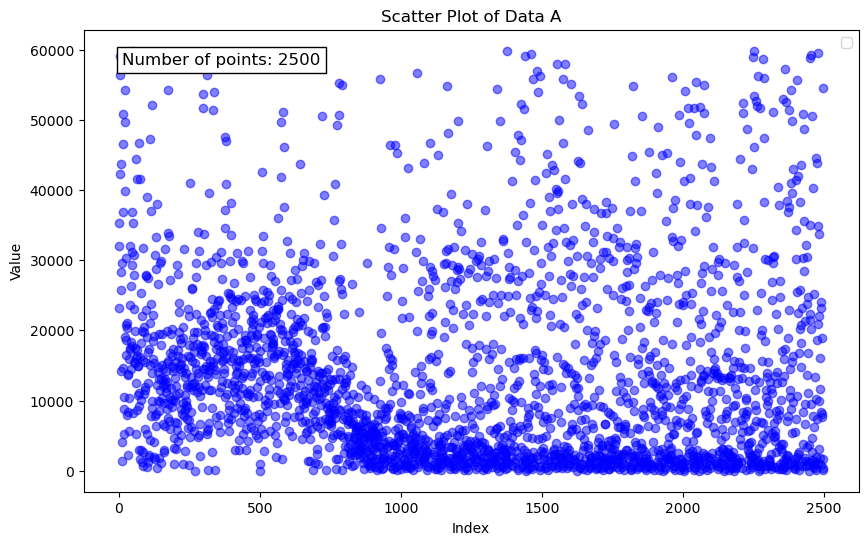

In [8]:
print(X_f_train.shape)
# 绘制散点图
plt.figure(figsize=(10, 6))
plt.scatter(np.arange(len(X_f_train)), X_f_train, alpha=0.5, color='blue')
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Scatter Plot of Data A')
# 在图中添加点的数量
plt.text(0.05, 0.95, f'Number of points: {len(X_f_train)}', transform=plt.gca().transAxes, 
         fontsize=12, verticalalignment='top', bbox=dict(facecolor='white', alpha=1))

plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(2500, 1)


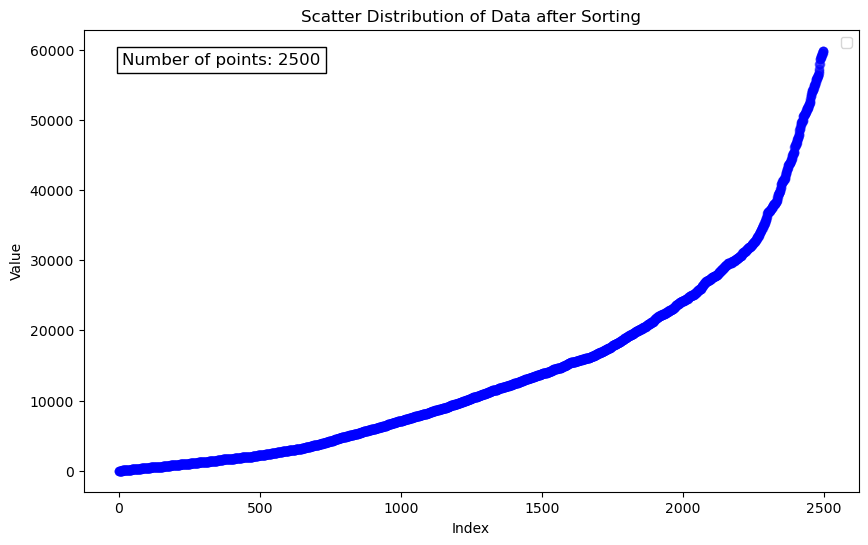

In [9]:
X = np.sort(X_f_train, axis=0)
print(X.shape)
# 绘制散点图
plt.figure(figsize=(10, 6))
plt.scatter(np.arange(len(X)), X, alpha=0.5, color='blue')
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Scatter Distribution of Data after Sorting')
# 在图中添加点的数量
plt.text(0.05, 0.95, f'Number of points: {len(X_f_train)}', transform=plt.gca().transAxes, 
         fontsize=12, verticalalignment='top', bbox=dict(facecolor='white', alpha=1))

plt.legend()
plt.show()

In [10]:
# 创建DataFrame
df = pd.DataFrame({'Seed': seeds, 'Error': error_y})

# 将DataFrame保存到CSV文件
df.to_csv('seeds_and_errors_fuhe.csv', index=False)

print("数据已保存到seeds_and_errors.csv文件中")

数据已保存到seeds_and_errors.csv文件中


In [11]:
print(seeds)
print(error_y)

error_of_u = sum(error_y)/len(error_y)

print('Error u of fuhe active learning(LHS sampling): %e' % (error_of_u)) #打印误差

print(error_mae)

error_of_mae = sum(error_mae)/len(error_mae)

print('MAE of fuhe active learning(LHS sampling): %e' % (error_of_mae)) #打印MAE

print(error_mse)

error_of_mse = sum(error_mse)/len(error_mse)

print('MSE of fuhe active learning(LHS sampling): %e' % (error_of_mse)) #打印MSE


[8906, 30414, 19997, 79957, 55853, 99438, 17715, 42674, 97805, 56382, 60657, 75478, 20161, 70579, 5506, 86879, 5562, 10712, 10432, 76078, 26002, 4367, 71027, 75144, 5423, 96542, 97407, 1251, 24010, 72817, 16195, 70599, 37761, 95319, 88326, 58646, 53937, 36297, 21411, 93932, 10733, 77855, 45717, 30700, 22746, 97990, 97591, 93206, 43502, 16228, 56093, 67707, 90923, 50475, 32314, 85533, 68625, 80550, 90413, 64944, 60938, 88697, 80327, 99021, 67781, 52438, 18213, 53755, 63537, 82672, 72192, 10130, 5649, 69169, 64026, 27219, 70514, 70064, 93292, 88433, 43312, 39283, 22046, 22017, 4779, 48009, 79834, 31429, 73667, 57132, 71312, 21860, 25657, 13923, 43140, 43106, 63193, 94994, 69985, 37369, 70117, 17196, 39378, 72911, 92026, 28810, 26335, 52398, 99110, 9859, 57350, 24427, 75209, 46879, 98222, 81616, 91622, 34088, 72375, 28603, 3722, 55182, 53873, 92638, 38872, 29472, 16475, 67983, 73099, 74955, 86767, 23951, 59769, 79995, 23040, 77891, 50321, 41673, 87810, 40328, 7758, 40340, 15547, 15479, 41

[0.03773733274601001, 0.042306344730805516, 0.039176363132308885, 0.03883123889006361, 0.0419015365426722, 0.035364455006176396, 0.038055498512324995, 0.04048240495412981, 0.03809150280781294, 0.04306798390081697, 0.03388591748343271, 0.03897153033144695, 0.04409301752944546, 0.0400559978356098, 0.04265077056119856, 0.03792560619707239, 0.04561416664349898, 0.03418140965907361, 0.04783726484247119, 0.036674630675173125, 0.03476657810227478, 0.038644232729070284, 0.0416342736696357, 0.04181769315177229, 0.04500127385204808, 0.04194273450252357, 0.038211978609370124, 0.03911269311647532, 0.0423066586796546, 0.04196893174030037, 0.040333787409851926, 0.035940580252095344, 0.040037363994746104, 0.04197158779204307, 0.04365078782984903, 0.03512322185959741, 0.04019432619580976, 0.04272839569452709, 0.039368310159201746, 0.03797403017931253, 0.04275477222111004, 0.03983299517459158, 0.03786421618869078, 0.041179339554830593, 0.0393078607381551, 0.03984979862884826, 0.039630780289479604, 0.04

/tmp/ipykernel_1811835/2285129262.py:37: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(error, shade=True, color="r", alpha=0.6)


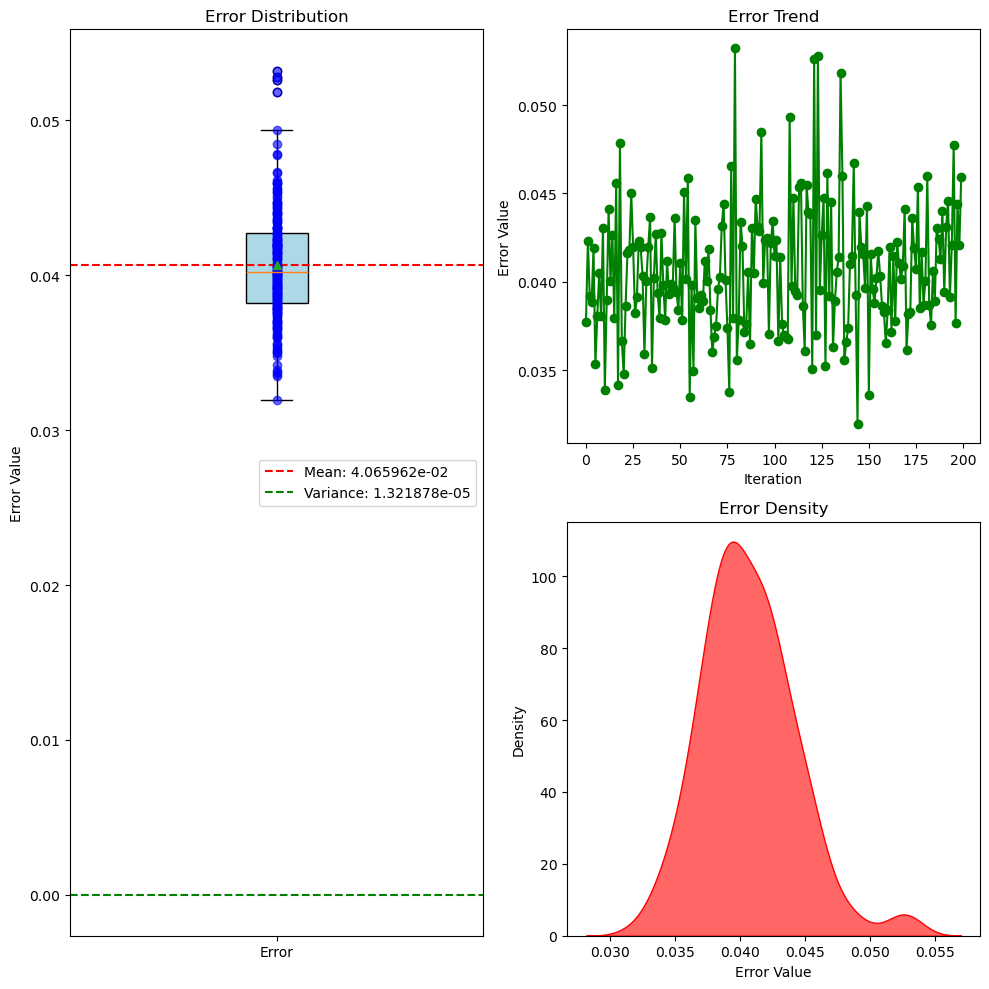

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns  # 导入seaborn库用于绘制密度图

# error = [0.5202765768338299, 0.5498189856925179, 0.8054262198745831, 0.2836623431751703, 0.7163985307835498, 0.8486951661259542, 0.45799139947295237, 1.0888879509613618, 0.18105234189218838, 0.5686642080465825]
error = error_y
print(error)

plt.figure(figsize=(10, 10))  # 调整整体图表尺寸

# 左侧子图：箱形图，占据两张图的位置，箱的上下边界为上下四分位数，箱内的横线+三角点为中位数，虚线为均值
plt.subplot(1, 2, 1)  # 第一个子图，现在布局为1行2列
mean_error = np.mean(error)
var_error = np.var(error)
print('mean Error u: %e' % (mean_error)) #打印误差
print('Variance Error u: %e' % (var_error)) #打印方差


plt.subplot(1, 2, 1)
plt.boxplot(error, patch_artist=True, showmeans=True, meanline=False, boxprops=dict(facecolor='lightblue'))
plt.axhline(mean_error, color='r', linestyle='--', label=f'Mean: {mean_error:e}')
plt.axhline(var_error, color='g', linestyle='--', label=f'Variance: {var_error:e}')  # 添加方差的水平线
for i, value in enumerate(error):
    plt.plot(1, value, 'bo', alpha=0.6)
plt.title('Error Distribution')
plt.ylabel('Error Value')
plt.xticks([1], ['Error'])
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(error, '-o', color='green')
plt.title('Error Trend')
plt.ylabel('Error Value')
plt.xlabel('Iteration')

plt.subplot(2, 2, 4)
sns.kdeplot(error, shade=True, color="r", alpha=0.6)
plt.title('Error Density')
plt.xlabel('Error Value')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

[0.018095273915753114, 0.021718037498846016, 0.020284614052097232, 0.0181636640882619, 0.0227366221937855, 0.01800595990749074, 0.02019293097173101, 0.021381981914197472, 0.019350618181267543, 0.021299709992456787, 0.01712901825454651, 0.02038904199292562, 0.021063705935721575, 0.02102577393287517, 0.021562267802561028, 0.020025645926699653, 0.022189132498509987, 0.018100779122953083, 0.022734541287463276, 0.018949731019070493, 0.018680864743631658, 0.01988355931552084, 0.02127968655947744, 0.02213459723280758, 0.02212700252367392, 0.01988232949434123, 0.020003697993452692, 0.019205911976233718, 0.02017533458372568, 0.02231087918954773, 0.020543594954625495, 0.018855154168867124, 0.0216297079624163, 0.022662238352449248, 0.020836402419902696, 0.018502211867520556, 0.01881311902734965, 0.019216877596922238, 0.01991205577800562, 0.020430125526281956, 0.022258747584709245, 0.021431425613700376, 0.019259720401892205, 0.021629354517303943, 0.020923497309345104, 0.019958141370563953, 0.02099

/tmp/ipykernel_1811835/3953849728.py:33: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(error, shade=True, color="r", alpha=0.6)


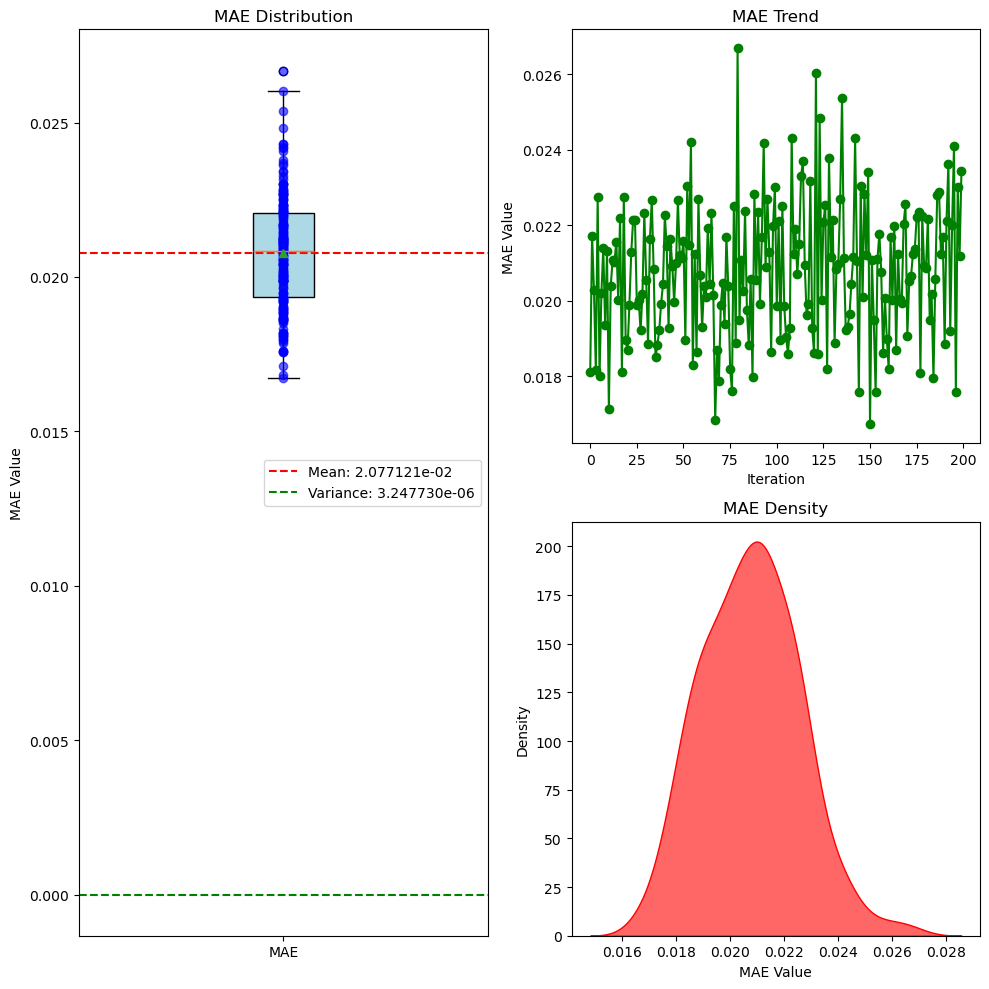

In [13]:

# error = [0.5202765768338299, 0.5498189856925179, 0.8054262198745831, 0.2836623431751703, 0.7163985307835498, 0.8486951661259542, 0.45799139947295237, 1.0888879509613618, 0.18105234189218838, 0.5686642080465825]
error = error_mae
print(error)

plt.figure(figsize=(10, 10))  # 调整整体图表尺寸

# 左侧子图：箱形图，占据两张图的位置，箱的上下边界为上下四分位数，箱内的横线+三角点为中位数，虚线为均值
plt.subplot(1, 2, 1)  # 第一个子图，现在布局为1行2列
mean_error = np.mean(error)
var_error = np.var(error)
print('mean MAE: %e' % (mean_error)) #打印误差
print('Variance MAE: %e' % (var_error)) #打印方差


plt.subplot(1, 2, 1)
plt.boxplot(error, patch_artist=True, showmeans=True, meanline=False, boxprops=dict(facecolor='lightblue'))
plt.axhline(mean_error, color='r', linestyle='--', label=f'Mean: {mean_error:e}')
plt.axhline(var_error, color='g', linestyle='--', label=f'Variance: {var_error:e}')  # 添加方差的水平线
for i, value in enumerate(error):
    plt.plot(1, value, 'bo', alpha=0.6)
plt.title('MAE Distribution')
plt.ylabel('MAE Value')
plt.xticks([1], ['MAE'])
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(error, '-o', color='green')
plt.title('MAE Trend')
plt.ylabel('MAE Value')
plt.xlabel('Iteration')

plt.subplot(2, 2, 4)
sns.kdeplot(error, shade=True, color="r", alpha=0.6)
plt.title('MAE Density')
plt.xlabel('MAE Value')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

[0.0005824257408959968, 0.0007832987029553353, 0.0006854775844851543, 0.0005937491224518354, 0.0008031102945976824, 0.0005538122778151399, 0.0006622299226965152, 0.0007527773491742449, 0.0006601371581262731, 0.0007692236002630302, 0.0005074378676168537, 0.0006837347438813041, 0.0007887599065451054, 0.0007087412095498093, 0.0007953736392183252, 0.0006448691662182343, 0.0008730747001617206, 0.0005301626920620599, 0.0009465457936781308, 0.0005943666706764348, 0.0005525243677360377, 0.0006552805721057481, 0.000751213884521917, 0.0007572051729584602, 0.0007872163289580252, 0.0006290647252836767, 0.0006616150165407473, 0.0006604342981519456, 0.0007185681061299, 0.0007985117205761131, 0.000719214493540712, 0.0005623086754882041, 0.0007303907695398007, 0.000809759075814674, 0.0007764375880181583, 0.000557998809235114, 0.0006249390122713079, 0.0006981623146997616, 0.0006756505923321845, 0.000653478447195733, 0.0008194965582343736, 0.0007179803586923554, 0.0006288958735381614, 0.0007757864568140

/tmp/ipykernel_1811835/3394972535.py:33: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(error, shade=True, color="r", alpha=0.6)


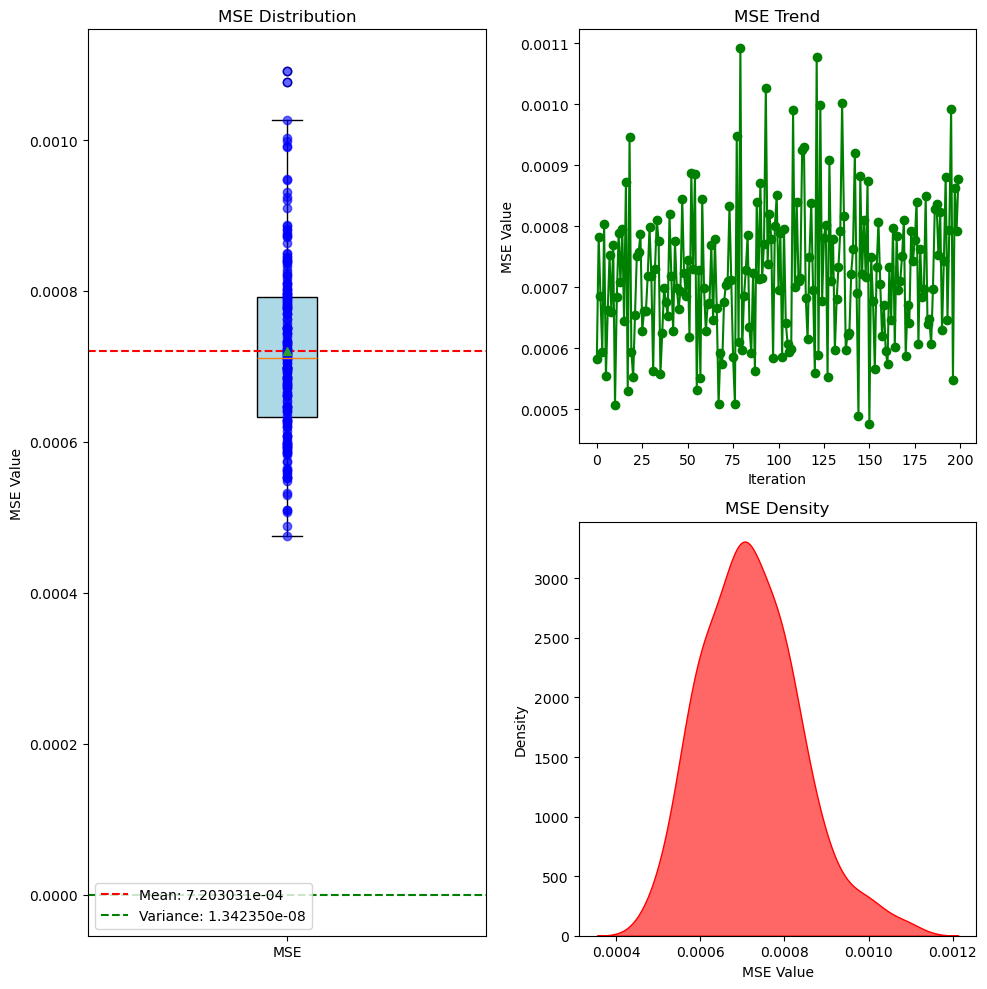

In [14]:

# error = [0.5202765768338299, 0.5498189856925179, 0.8054262198745831, 0.2836623431751703, 0.7163985307835498, 0.8486951661259542, 0.45799139947295237, 1.0888879509613618, 0.18105234189218838, 0.5686642080465825]
error = error_mse
print(error)

plt.figure(figsize=(10, 10))  # 调整整体图表尺寸

# 左侧子图：箱形图，占据两张图的位置，箱的上下边界为上下四分位数，箱内的横线+三角点为中位数，虚线为均值
plt.subplot(1, 2, 1)  # 第一个子图，现在布局为1行2列
mean_error = np.mean(error)
var_error = np.var(error)
print('mean MSE: %e' % (mean_error)) #打印误差
print('Variance MSE: %e' % (var_error)) #打印方差


plt.subplot(1, 2, 1)
plt.boxplot(error, patch_artist=True, showmeans=True, meanline=False, boxprops=dict(facecolor='lightblue'))
plt.axhline(mean_error, color='r', linestyle='--', label=f'Mean: {mean_error:e}')
plt.axhline(var_error, color='g', linestyle='--', label=f'Variance: {var_error:e}')  # 添加方差的水平线
for i, value in enumerate(error):
    plt.plot(1, value, 'bo', alpha=0.6)
plt.title('MSE Distribution')
plt.ylabel('MSE Value')
plt.xticks([1], ['MSE'])
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(error, '-o', color='green')
plt.title('MSE Trend')
plt.ylabel('MSE Value')
plt.xlabel('Iteration')

plt.subplot(2, 2, 4)
sns.kdeplot(error, shade=True, color="r", alpha=0.6)
plt.title('MSE Density')
plt.xlabel('MSE Value')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

[35.397163, 1321.2361, 10.876525, 0.0016289958, 0.0017533578, 180.26358, 20462.855, 0.26507127, 13.224324, 7920.504, 205.40471, 104.15689, 3.3192372, 3243.3828, 965.0897, 19207.838, 0.0016488612, 179.61353, 3335.7378, 0.0067490516, 643.79193, 0.16980621, 0.04424011, 0.032910794, 0.0014066163, 4062.0474, 89.16133, 0.0049293134, 0.0010856229, 0.0015627992, 0.0014073321, 0.09272959, 9823.932, 8.05646, 20.718102, 0.0019325414, 0.0015662139, 0.00200904, 0.0012691354, 6298.9385, 1.1833861, 17.050264, 0.0014120876, 0.0052580982, 5.31762, 380.35434, 8.732349, 1.0661266, 0.0034529911, 0.001723746, 529.47, 0.0020484477, 6666.189, 206.54752, 12.87789, 0.038006466, 1200.2168, 0.0014653327, 74.290924, 0.655906, 0.26778325, 0.028971042, 0.15740125, 0.90091866, 333.01114, 17329.82, 0.0014054615, 0.0015876838, 70.26283, 0.0015312721, 73.02104, 0.0026417691, 119.33869, 0.003453031, 6190.499, 14.901937, 742.86523, 166.52835, 0.001553217, 676.8596, 0.0028037422, 0.10723418, 73.298485, 0.5693109, 0.002258

/tmp/ipykernel_1811835/1804867946.py:33: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(error, shade=True, color="r", alpha=0.6)


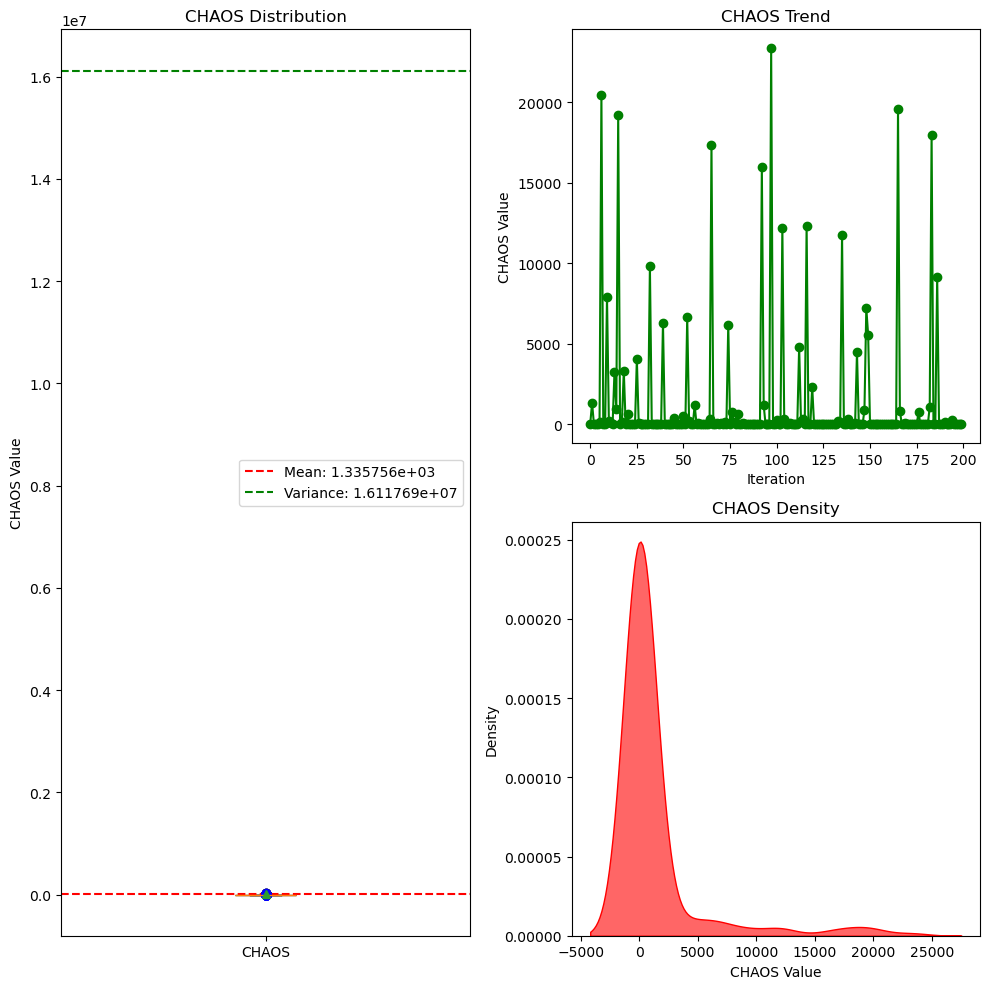

In [15]:

# error = [0.5202765768338299, 0.5498189856925179, 0.8054262198745831, 0.2836623431751703, 0.7163985307835498, 0.8486951661259542, 0.45799139947295237, 1.0888879509613618, 0.18105234189218838, 0.5686642080465825]
error = chaoss
print(error)

plt.figure(figsize=(10, 10))  # 调整整体图表尺寸

# 左侧子图：箱形图，占据两张图的位置，箱的上下边界为上下四分位数，箱内的横线+三角点为中位数，虚线为均值
plt.subplot(1, 2, 1)  # 第一个子图，现在布局为1行2列
mean_error = np.mean(error)
var_error = np.var(error)
print('mean CHAOS: %e' % (mean_error)) #打印误差
print('Variance CHAOS: %e' % (var_error)) #打印方差


plt.subplot(1, 2, 1)
plt.boxplot(error, patch_artist=True, showmeans=True, meanline=False, boxprops=dict(facecolor='lightblue'))
plt.axhline(mean_error, color='r', linestyle='--', label=f'Mean: {mean_error:e}')
plt.axhline(var_error, color='g', linestyle='--', label=f'Variance: {var_error:e}')  # 添加方差的水平线
for i, value in enumerate(error):
    plt.plot(1, value, 'bo', alpha=0.6)
plt.title('CHAOS Distribution')
plt.ylabel('CHAOS Value')
plt.xticks([1], ['CHAOS'])
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(error, '-o', color='green')
plt.title('CHAOS Trend')
plt.ylabel('CHAOS Value')
plt.xlabel('Iteration')

plt.subplot(2, 2, 4)
sns.kdeplot(error, shade=True, color="r", alpha=0.6)
plt.title('CHAOS Density')
plt.xlabel('CHAOS Value')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

[3.1211016e-08, 3.4327286e-08, 3.086666e-08, 3.3468723e-08, 3.5340236e-08, 3.31446e-08, 3.5743028e-08, 3.2319917e-08, 3.2716912e-08, 3.0420097e-08, 2.9589387e-08, 3.2197477e-08, 3.783464e-08, 3.0170554e-08, 3.7350674e-08, 3.1016725e-08, 3.5735866e-08, 3.1707486e-08, 3.5212224e-08, 2.7499937e-08, 3.528976e-08, 2.838874e-08, 2.9296189e-08, 3.086643e-08, 2.8201612e-08, 2.5597387e-08, 3.0073124e-08, 3.8661454e-08, 3.3864012e-08, 2.6161388e-08, 3.5216317e-08, 2.8440581e-08, 2.8177055e-08, 3.869968e-08, 3.3944502e-08, 3.0925435e-08, 3.678744e-08, 3.185687e-08, 3.4978825e-08, 3.573598e-08, 2.9928515e-08, 2.9365538e-08, 2.7419333e-08, 3.5169023e-08, 3.0344154e-08, 3.334054e-08, 3.0696015e-08, 2.9493663e-08, 3.2001253e-08, 3.0757974e-08, 3.182663e-08, 3.186858e-08, 3.354762e-08, 3.246049e-08, 2.9753437e-08, 3.0761157e-08, 3.1634272e-08, 2.8613272e-08, 3.1916215e-08, 3.3499873e-08, 3.2631988e-08, 2.919171e-08, 3.3100264e-08, 3.2509206e-08, 2.8983322e-08, 3.264688e-08, 3.5763833e-08, 3.2123808e-0

/tmp/ipykernel_1811835/2986457676.py:33: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(error, shade=True, color="r", alpha=0.6)


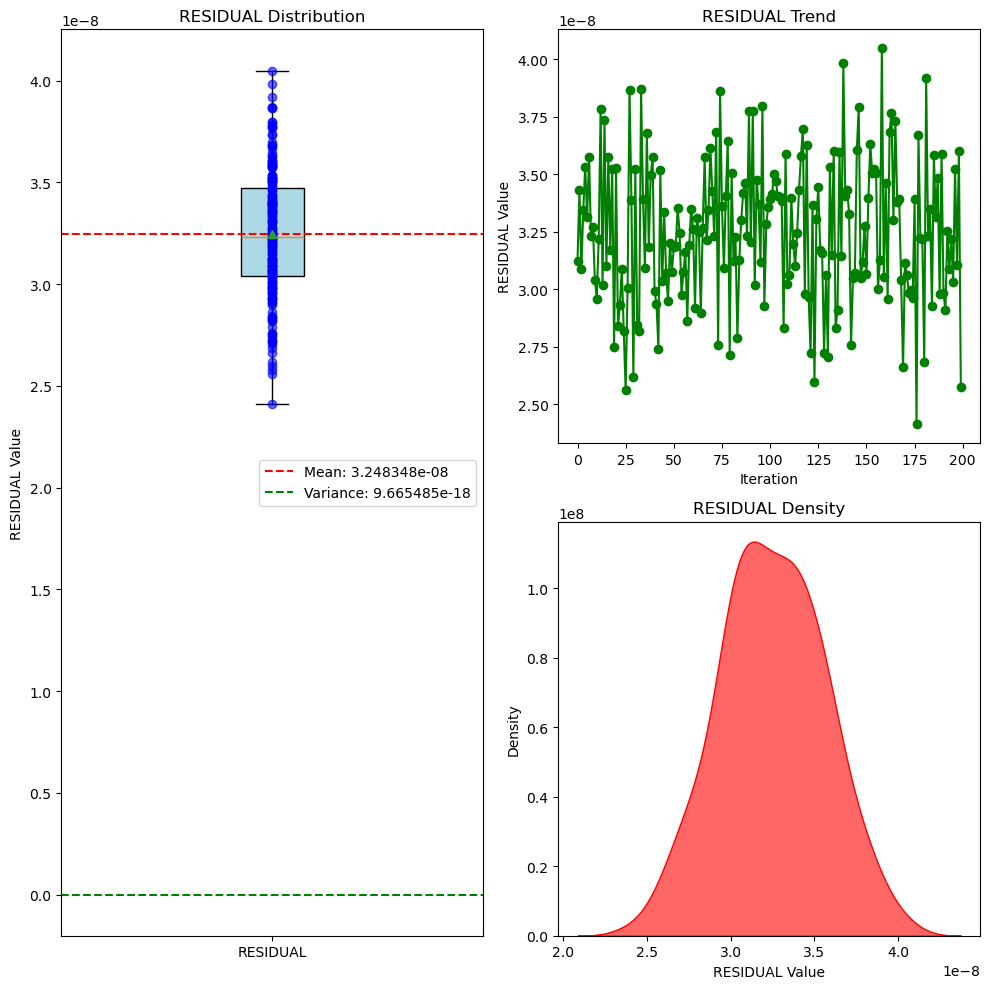

In [16]:

# error = [0.5202765768338299, 0.5498189856925179, 0.8054262198745831, 0.2836623431751703, 0.7163985307835498, 0.8486951661259542, 0.45799139947295237, 1.0888879509613618, 0.18105234189218838, 0.5686642080465825]
error = residuals
print(error)

plt.figure(figsize=(10, 10))  # 调整整体图表尺寸

# 左侧子图：箱形图，占据两张图的位置，箱的上下边界为上下四分位数，箱内的横线+三角点为中位数，虚线为均值
plt.subplot(1, 2, 1)  # 第一个子图，现在布局为1行2列
mean_error = np.mean(error)
var_error = np.var(error)
print('mean RESIDUAL: %e' % (mean_error)) #打印误差
print('Variance RESIDUAL: %e' % (var_error)) #打印方差


plt.subplot(1, 2, 1)
plt.boxplot(error, patch_artist=True, showmeans=True, meanline=False, boxprops=dict(facecolor='lightblue'))
plt.axhline(mean_error, color='r', linestyle='--', label=f'Mean: {mean_error:e}')
plt.axhline(var_error, color='g', linestyle='--', label=f'Variance: {var_error:e}')  # 添加方差的水平线
for i, value in enumerate(error):
    plt.plot(1, value, 'bo', alpha=0.6)
plt.title('RESIDUAL Distribution')
plt.ylabel('RESIDUAL Value')
plt.xticks([1], ['RESIDUAL'])
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(error, '-o', color='green')
plt.title('RESIDUAL Trend')
plt.ylabel('RESIDUAL Value')
plt.xlabel('Iteration')

plt.subplot(2, 2, 4)
sns.kdeplot(error, shade=True, color="r", alpha=0.6)
plt.title('RESIDUAL Density')
plt.xlabel('RESIDUAL Value')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

In [17]:
trainloss = torch.stack(model.loss_value).cpu().detach().numpy()

80000
[2.8693706e-01 2.6864624e-01 2.5003111e-01 ... 2.2174995e-09 2.2174644e-09
 2.2187383e-09]


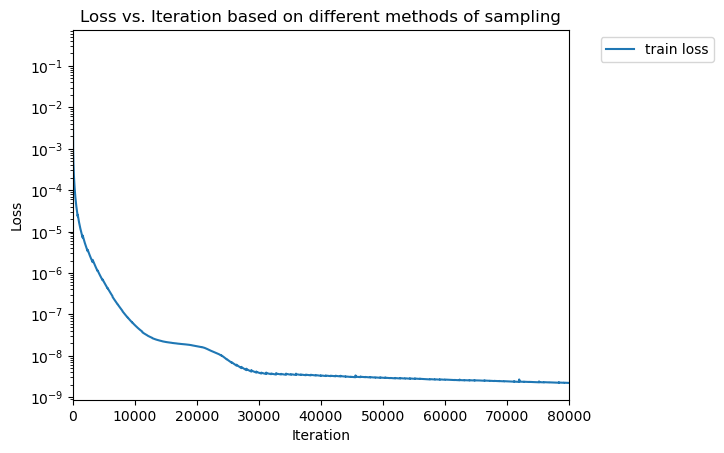

In [18]:
print(len(trainloss))
print(trainloss)
# 定义图例的标签
labels = ["Grid"]

# 创建一个新的图形
plt.figure()

# # 遍历所有的loss数据和标签
# for loss, label in zip(trainloss, labels):
#     # 绘制每个loss数据，并使用标签作为图例的条目
#     plt.plot(loss, label=label)

plt.plot(trainloss, label='train loss')

# 添加图例，放在图像外
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')


plt.xlim([0,80000]) # 设置x轴的范围
plt.yscale('log') #设置y轴为对数尺度，这样即使列表中有一些非常大的值，也不会影响其他值的可视化
plt.xlabel('Iteration') # 设置x轴的标签
plt.ylabel('Loss') # 设置y轴的标签
plt.title('Loss vs. Iteration based on different methods of sampling') # 设置图形的标题
# 显示图形
plt.show()
plt.show()

Text(0, 0.5, 'Probability')

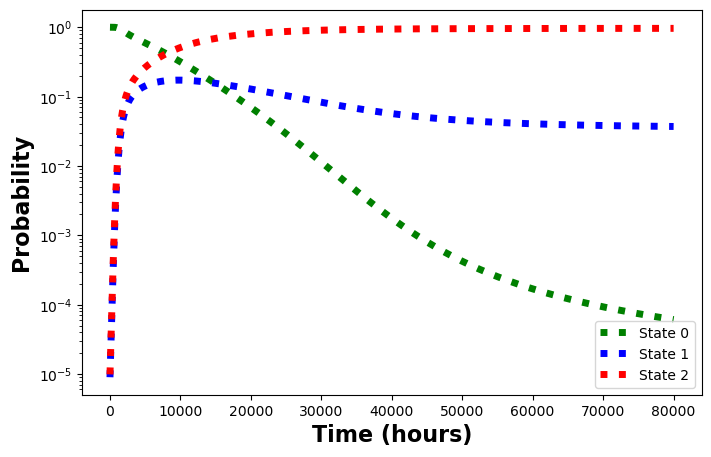

In [19]:
plt.figure(figsize=(8, 5)) #设置图形尺寸为8*5

sns.lineplot(x = x_star.flatten(), y = y_pred[:, 0], label = 'State 0', linewidth = 5, color = 'green', linestyle='dotted')
#绘制第一条折线图，横坐标为x_star，代表不同的时刻，纵坐标为exact_solution_Laplace数据的第一列，设置这条线的标签为State 0，线宽为5，颜色为绿色，线型为点线
sns.lineplot(x = x_star.flatten(), y = y_pred[:, 1], label = 'State 1', linewidth = 5, color = 'blue', linestyle='dotted')
#绘制第二条折线图，横坐标为x_star，代表不同的时刻，纵坐标为exact_solution_Laplace数据的第二列，设置这条线的标签为State 1，线宽为5，颜色为蓝色，线型为点线
sns.lineplot(x = x_star.flatten(), y = y_pred[:, 2], label = 'State 2', linewidth = 5, color = 'red', linestyle='dotted')
#绘制第三条折线图，横坐标为x_star，代表不同的时刻，纵坐标为exact_solution_Laplace数据的第三列，设置这条线的标签为State 2，线宽为5，颜色为红色，线型为点线

plt.yscale('log') #设置y轴的刻度为对数刻度
plt.xlabel("Time (hours)", fontdict=dict(weight='bold'), fontsize=16) #设置x轴标签为Time (hours)，字体加粗，字体大小为16
plt.ylabel("Probability", fontdict=dict(weight='bold'), fontsize=16) #设置y轴标签为Probability，字体加粗，字体大小为16

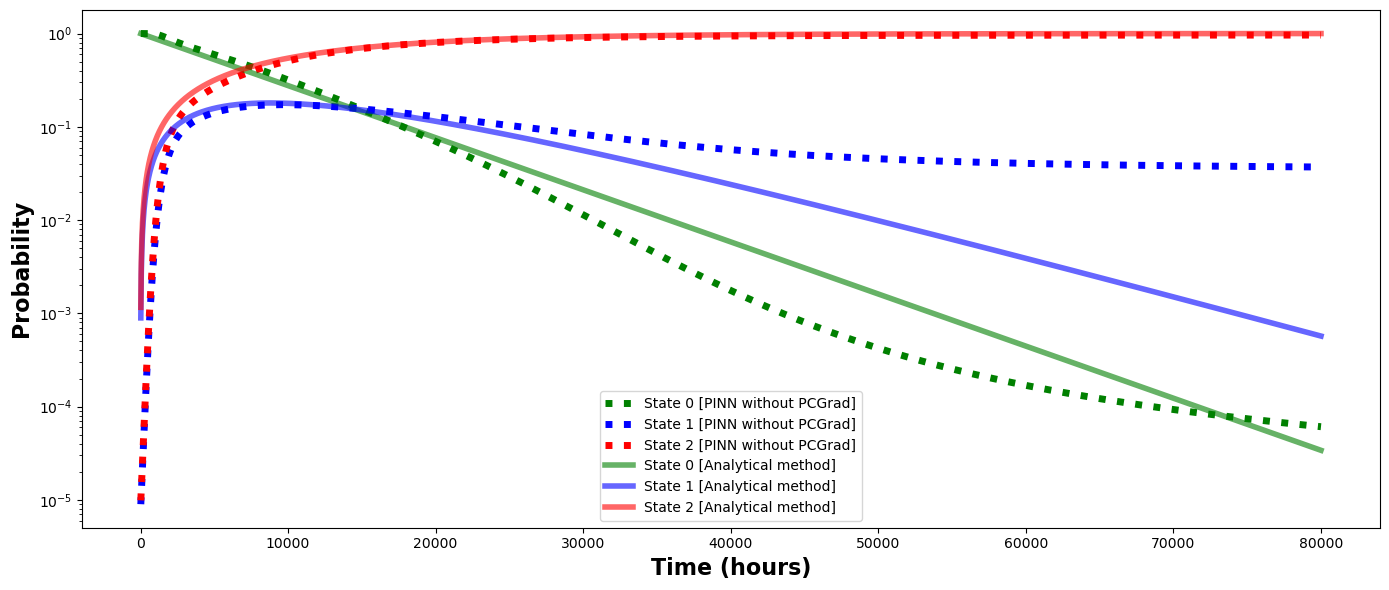

In [20]:
# 创建一个子图
f, ax = plt.subplots(1, 1, figsize=(14, 6))

# 绘制 PINN without PCGrad 方法的预测结果
sns.lineplot(x=x_star.flatten(), y=y_pred[:, 0], label='State 0 [PINN without PCGrad]', linewidth=5, color='green', linestyle='dotted', ax=ax)
sns.lineplot(x=x_star.flatten(), y=y_pred[:, 1], label='State 1 [PINN without PCGrad]', linewidth=5, color='blue', linestyle='dotted', ax=ax)
sns.lineplot(x=x_star.flatten(), y=y_pred[:, 2], label='State 2 [PINN without PCGrad]', linewidth=5, color='red', linestyle='dotted', ax=ax)

# 绘制 Runge-Kutta 方法的结果
sns.lineplot(x=x_star.flatten(), y=eigenvector_solution_df['state_0'], label='State 0 [Analytical method]', color='green', alpha=0.6, dashes=True, linewidth=4, ax=ax)
sns.lineplot(x=x_star.flatten(), y=eigenvector_solution_df['state_1'], label='State 1 [Analytical method]', color='blue', alpha=0.6, dashes=True, linewidth=4, ax=ax)
sns.lineplot(x=x_star.flatten(), y=eigenvector_solution_df['state_2'], label='State 2 [Analytical method]', color='red', alpha=0.6, dashes=True, linewidth=4, ax=ax)


# 设置 y 轴为对数刻度
ax.set_yscale("log")
# ax.set_ylim([1e-9, 2])
ax.set_xlabel("Time (hours)", fontdict=dict(weight='bold'), fontsize=16)
ax.set_ylabel("Probability", fontdict=dict(weight='bold'), fontsize=16)

# 自动调整子图参数
plt.tight_layout()


# 显示图形
plt.show()

### 计算RMSE

In [21]:
y_pred_df = pd.DataFrame(y_pred, columns = ['state_0', 'state_1', 'state_2'])
print(y_pred_df.head())
print(y_pred_df.tail())

    state_0   state_1   state_2
0  0.999981  0.000009  0.000010
1  0.999978  0.000010  0.000011
2  0.999975  0.000012  0.000013
3  0.999972  0.000013  0.000015
4  0.999968  0.000015  0.000017
       state_0   state_1   state_2
4995  0.000061  0.037087  0.962852
4996  0.000061  0.037086  0.962853
4997  0.000061  0.037084  0.962855
4998  0.000061  0.037083  0.962856
4999  0.000061  0.037081  0.962858


In [22]:
y_diff_no_pcgrad_eigenvectors = eigenvector_solution_df - y_pred_df #解析方法（特征向量）和PINN方法差值

In [23]:
### PINN和解析方法的RMSE计算
#计算MSE，对PINN和解析方法的差值的每一行应用一个匿名函数，计算三个状态的平方和，结果存储在DataFrame的新列'mse'中
y_diff_no_pcgrad_eigenvectors['mse'] = y_diff_no_pcgrad_eigenvectors.apply(lambda x: x['state_0']**2 + x['state_1']**2 + x['state_2']**2, axis = 1)
#计算RMSE，对'mse'列应用np.sqrt函数，结果存储在DataFrame的新列'rmse'中
y_diff_no_pcgrad_eigenvectors['rmse'] = y_diff_no_pcgrad_eigenvectors['mse'].apply(np.sqrt)

In [24]:
#0-80000个时间的RMSE
print ('RMSE of between PINN without PCGrad and the analytical solution is', np.mean(y_diff_no_pcgrad_eigenvectors['rmse']))

#前60000个时间的RMSE，3749/5000=60000/80000
print ('RMSE between PINN without PCGrad and the analytical solution before 60000 is', 
       np.mean(y_diff_no_pcgrad_eigenvectors['rmse'][:3749]))

#60000到80000的RMSE
print ('RMSE between PINN without PCGrad and the analytical solution after 60000 is', 
       np.mean(y_diff_no_pcgrad_eigenvectors['rmse'][3749:]))

RMSE of between PINN without PCGrad and the analytical solution is 0.047027943465885014
RMSE between PINN without PCGrad and the analytical solution before 60000 is 0.045415823060684014
RMSE between PINN without PCGrad and the analytical solution after 60000 is 0.05185915001992063


### 计算混沌度和残差

In [25]:
x_star.shape

(5000, 1)

In [26]:
#计算chaos
y_chaos = model.hidden_predict(x_star, 100)
# print(y_chaos)
x_sss = x_star + np.random.normal(1000, 0.01)
y_chaos_sss = model.hidden_predict(x_sss, 50)
chaju = np.linalg.norm(y_chaos - y_chaos_sss,axis=1)
print(chaju)
print(chaju.shape)
print(chaju.sum())

[1.38507439e-05 1.38998685e-05 1.37251282e-05 ... 7.12522024e-06
 7.13288136e-06 7.86431519e-06]
(5000,)
174.59747


In [27]:
#计算残差
_, residual = model.predict(x_star)
residual = residual.flatten()
print(residual)
print(residual.shape)
print(residual.sum())

[-2.8376235e-10  1.3096724e-10  1.2369128e-10 ... -2.2737368e-13
 -2.2737368e-13 -6.8212103e-13]
(5000,)
4.879439e-10
